In [34]:
import pandas                          as      pd
import numpy                           as      np
import matplotlib.pyplot               as      plt
from   IPython.display                 import  display
from   pylab                           import  rcParams 
from   datetime                        import  datetime, timedelta
from   pandas.tseries.offsets          import BDay
from statsmodels.tsa.stattools         import  adfuller
from statsmodels.tsa.stattools         import  pacf
from statsmodels.tsa.stattools         import  acf
from statsmodels.graphics.tsaplots     import  plot_pacf
from statsmodels.graphics.tsaplots     import  plot_acf
from statsmodels.graphics.gofplots     import  qqplot
from statsmodels.tsa.seasonal          import  seasonal_decompose
from   statsmodels.tsa.api             import  ExponentialSmoothing,Holt
from statsmodels.tsa.arima_model       import  ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX 
from sklearn.metrics                   import  mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import itertools
import seaborn as sns

# Data With Only Trend

### Pre-processing the Data

In [48]:
df_spend = pd.read_csv('data/data_set.csv', parse_dates=True)
df_spend.head(5)

,Date,Avg spending
0,04-02-2019,62.58
1,05-02-2019,64.27
2,06-02-2019,63.44
3,07-02-2019,61.50
4,08-02-2019,61.16


In [49]:
df_spend.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 605 entries, 0 to 604
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          605 non-null    object 
 1   Avg spending  605 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.6+ KB


##### Convert to TimeSeries Data

In [50]:
# Data in incorrect format
df_spend['Date'] = pd.to_datetime( df_spend['Date'], format='%d-%m-%Y')
df_spend.set_index(keys='Date', inplace=True)
df_spend.index.freq = 'D'
df_spend.head()

,Avg spending
Date,
2019-02-04,62.58
2019-02-05,64.27
2019-02-06,63.44
2019-02-07,61.50
2019-02-08,61.16


##### Check for missing values

In [51]:
df_spend.isnull().sum()

Avg spending    0
dtype: int64

In [52]:
df_spend.isna().value_counts()

Avg spending
False           605
dtype: int64

### Visualize the Data

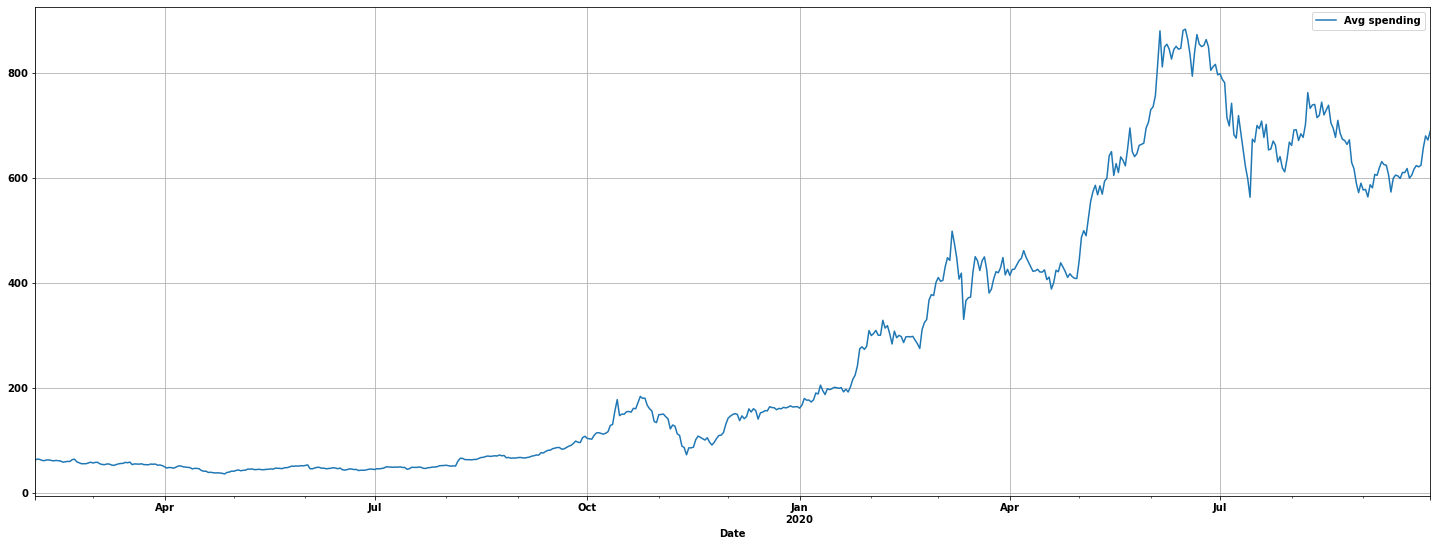

In [53]:
plt.rcParams['figure.figsize'] = (25, 9)
df_spend.plot(grid=True)
plt.show()

In [54]:
import seaborn as sns

<AxesSubplot:xlabel='Date', ylabel='Avg spending'>

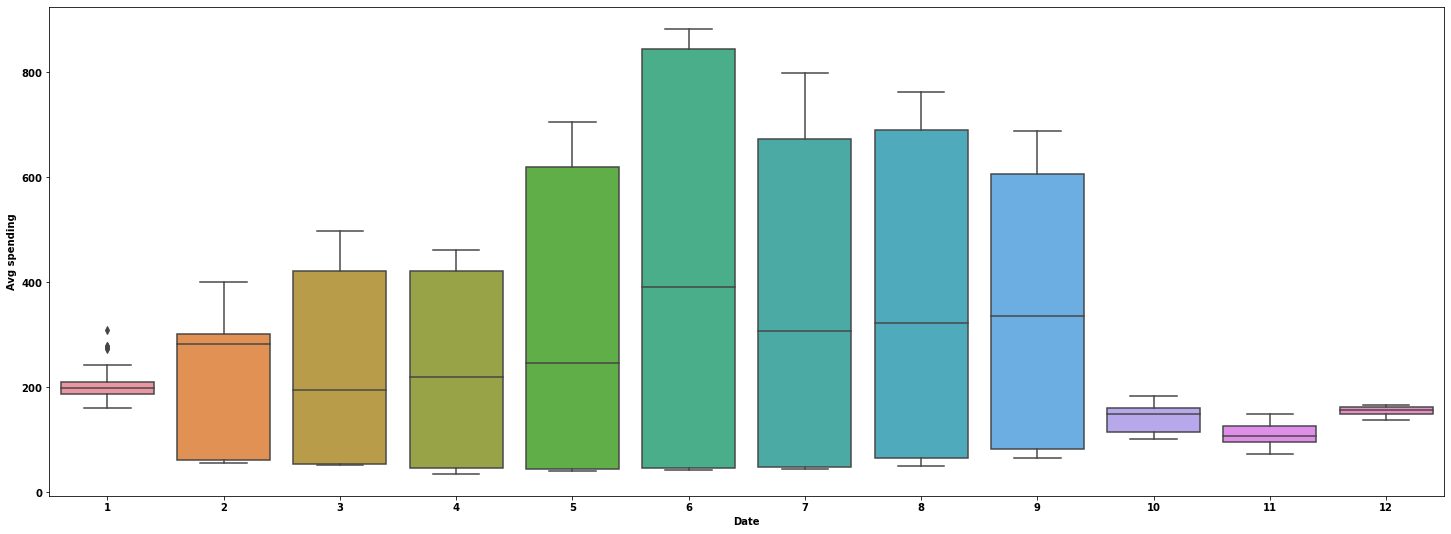

In [55]:
sns.boxplot(x=df_spend.index.month, y=df_spend['Avg spending'])

In [56]:
df_spend.pivot_table(index=df_spend.index.month, columns=df_spend.index.year, values='Avg spending')

Date,2019,2020
Date,,
1,NaN,207.957097
2,60.153600,312.761379
3,54.742581,419.652258
4,43.812333,423.340333
5,46.000645,605.668710
6,45.858333,831.932333
7,48.142903,676.979677
8,64.195806,685.964194
9,81.599667,613.464000


# Decomposition of Data

##### Additive Decomposition

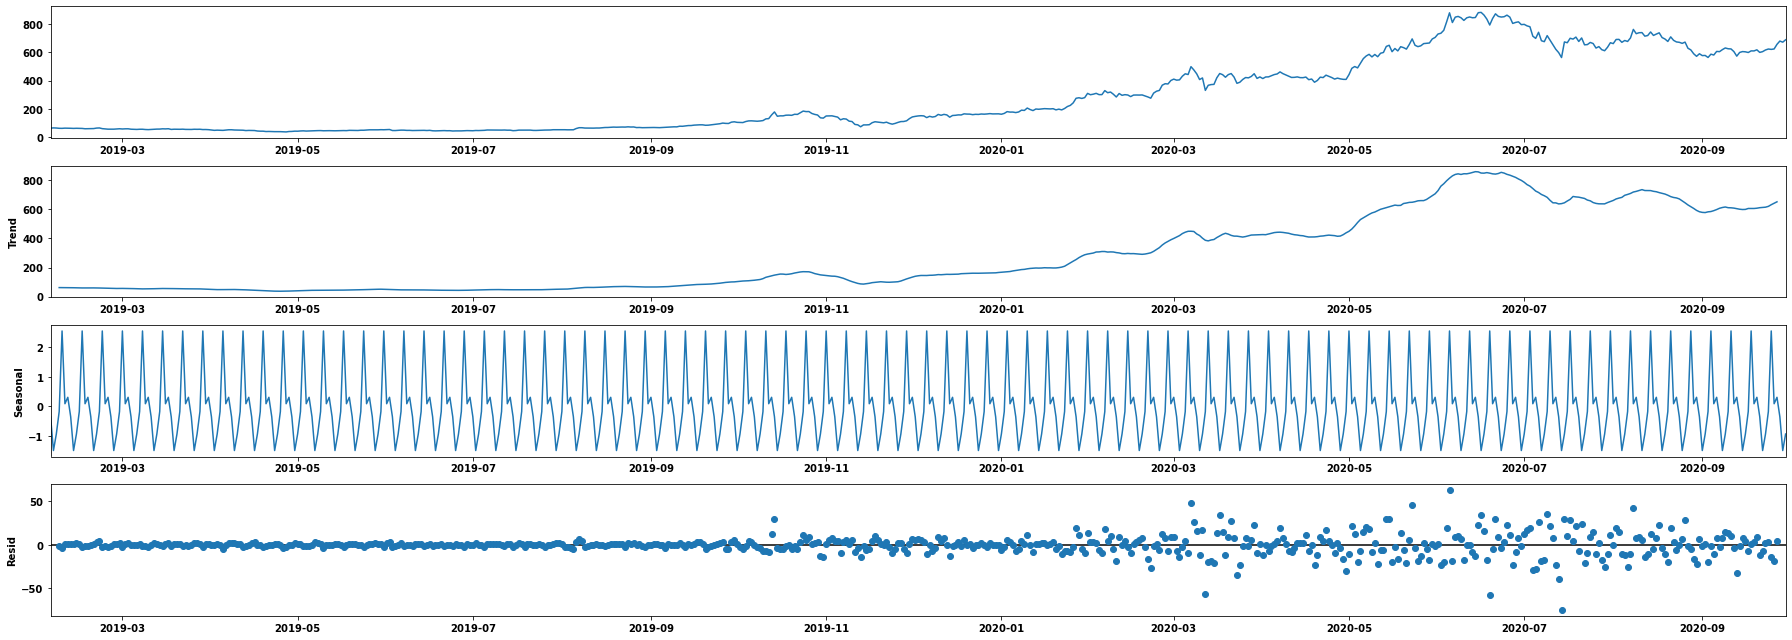

In [57]:
seasonal_decompose(x=df_spend, model='additive').plot();

##### Multiplicative Decomposition

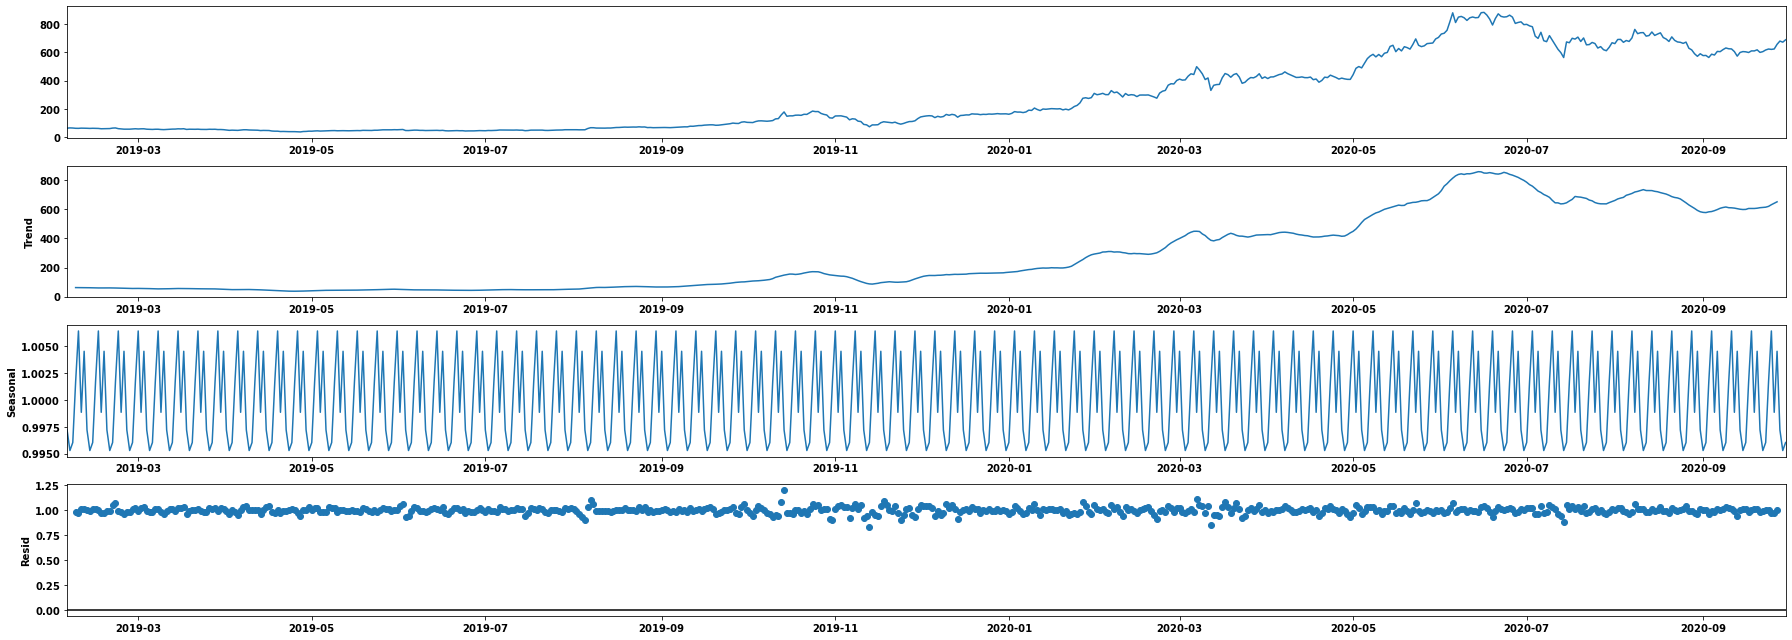

In [58]:
seasonal_decompose(x=df_spend, model='multiplicative').plot();

In [59]:
seasonal_decompose(x=df_spend, model='additive').resid.mean(), seasonal_decompose(x=df_spend, model='multiplicative').resid.mean() 

(-0.06328738937433456, 0.9991711842488951)

In [61]:
print(f'''
Observation: This is an additive series since the seasonal variation does NOT depend on Trend
Mean of Residue of Additive is almost 0 ~ {seasonal_decompose(x=df_spend, model='additive').resid.mean()} ''')


Observation: This is an additive series since the seasonal variation does NOT depend on Trend
Mean of Residue of Additive is almost 0 ~ -0.06328738937433456 


<AxesSubplot:xlabel='Date'>

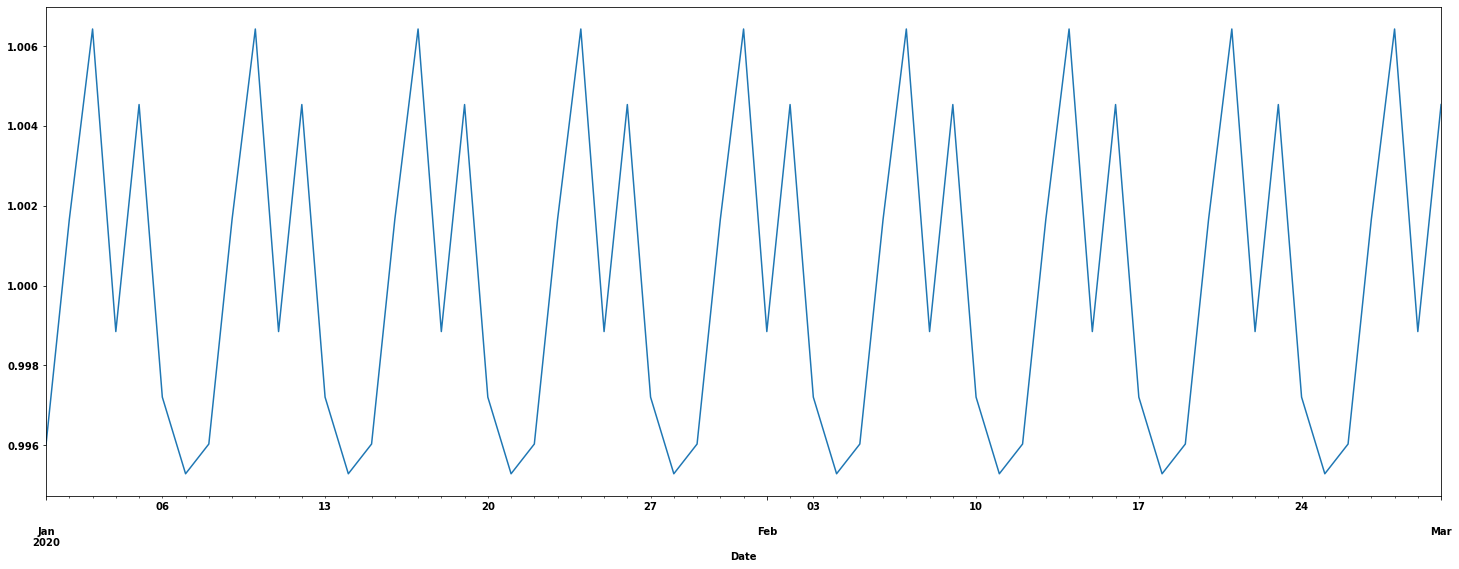

In [14]:
seasonal_decompose(x=df_spend, model='multiplicative').seasonal['2020-01-01': '2020-03-01'].plot()

<AxesSubplot:xlabel='Date'>

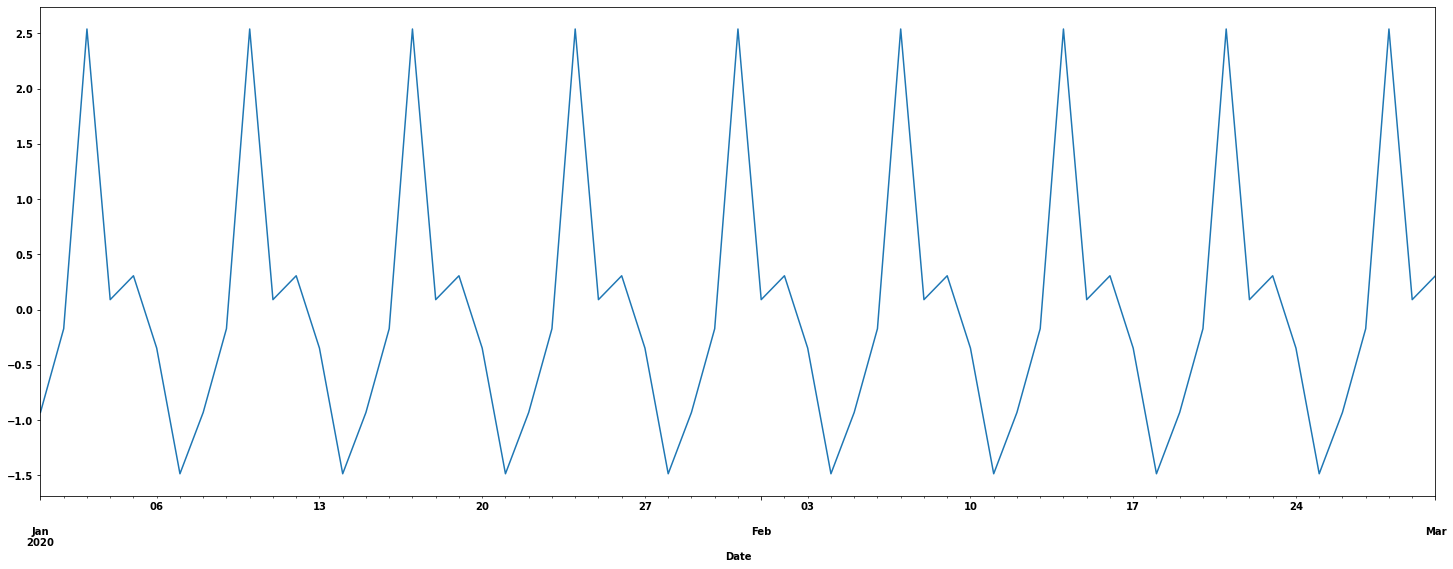

In [15]:
seasonal_decompose(x=df_spend, model='additive').seasonal['2020-01-01': '2020-03-01'].plot()

In [16]:
print('''Observation:
Decomposition plot shows that Trend component of time series is significant. 
Decomposition plot shows that there is no seasonality in time series. 
Resdiuals are normally distributed with 0 mean.
Since we have Trend and no Seasonality its better to use the Holt Model (Double Exponential Smoothing)''')

Observation:
Decomposition plot shows that Trend component of time series is significant. 
Decomposition plot shows that there is no seasonality in time series. 
Resdiuals are normally distributed with 0 mean.
Since we have Trend and no Seasonality its better to use the Holt Model (Double Exponential Smoothing)


# Stationarity Check

In [17]:
adf_results = adfuller(df_spend.values)
adf_results

(-0.30908265623618336,
 0.9242080692970703,
 9,
 595,
 {'1%': -3.441388211993052,
  '5%': -2.8664097967491498,
  '10%': -2.569363480686392},
 4908.380183800914)

In [18]:
print(f'''
ADF Statistic: {adf_results[0]}
p-Value: {adf_results[1]}
Critical Values:''')
for key, val in adf_results[4].items():
    print(f'\t{key}: {val}')


ADF Statistic: -0.30908265623618336
p-Value: 0.9242080692970703
Critical Values:
	1%: -3.441388211993052
	5%: -2.8664097967491498
	10%: -2.569363480686392


In [19]:
print('''
Observation: Test results confirms that the series is non-stationary at the confidence level of 99%. To make series stationary, will use differencing''')


Observation: Test results confirms that the series is non-stationary at the confidence level of 99%. To make series stationary, will use differencing


In [20]:
df_spend_diff= df_spend.diff().dropna()
df_spend_diff.head()

,Avg spending
Date,
2019-02-05,1.69
2019-02-06,-0.83
2019-02-07,-1.94
2019-02-08,-0.34
2019-02-09,1.41


In [21]:
adf_results = adfuller(df_spend_diff.values)
print(f'''
ADF Statistic: {adf_results[0]}
p-Value: {adf_results[1]}
Critical Values:''')
for key, val in adf_results[4].items():
    print(f'\t{key}: {val}')


ADF Statistic: -6.731902702457806
p-Value: 3.2798705231970324e-09
Critical Values:
	1%: -3.441388211993052
	5%: -2.8664097967491498
	10%: -2.569363480686392


In [22]:
print('''
Observation: After first order differencing, series becomes stationary''')


Observation: After first order differencing, series becomes stationary


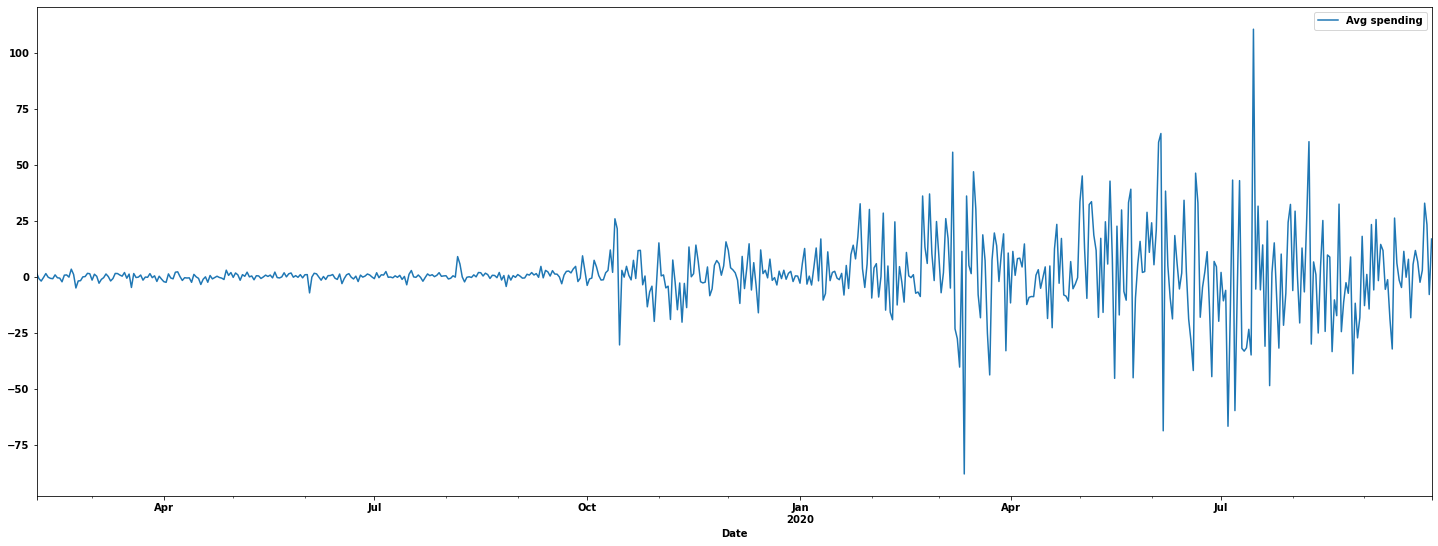

In [23]:
df_spend_diff.plot()
plt.show()

### AutoCorrelation (ACF) and PartialAutoCorrelation (PACF) Plots

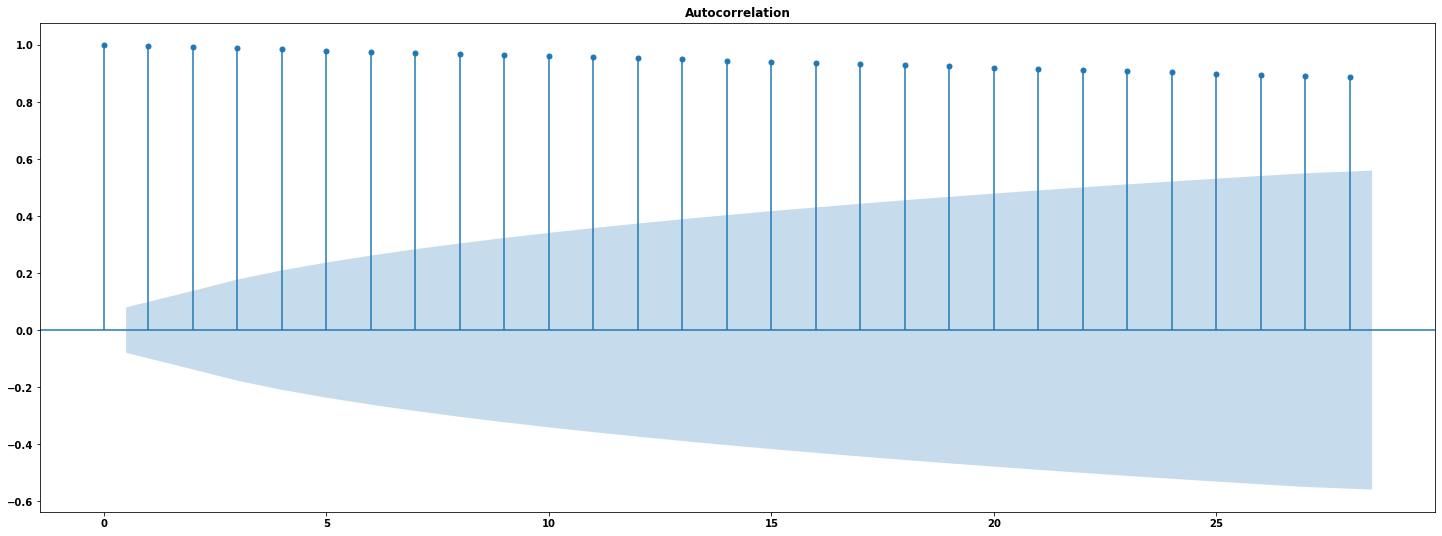

In [24]:
plot_acf(df_spend);
plt.show()

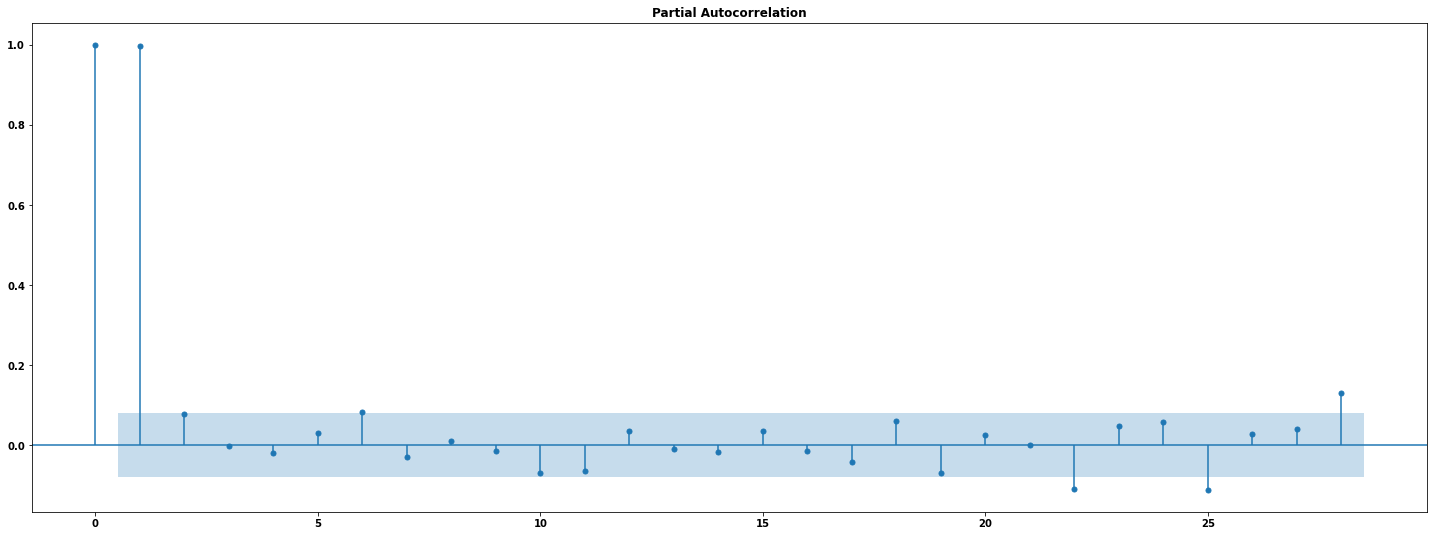

In [25]:
plot_pacf(df_spend);
plt.show()

In [26]:
print('''Observation: Based on Patial Autocorrelation (PACF) plot its a AR(1) process (p=1) ''')

Observation: Based on Patial Autocorrelation (PACF) plot its a AR(1) process (p=1) 


In [27]:
print('''Observation: ACF Plot is showing very slow decay. Whereas PACF plot shows cut-off after first lag. 
This is because, series has strong trend component and results into more significant lags in ACF plot. 
ACF and PACF plots confirms that series shows AR process characteristic. ''')

Observation: ACF Plot is showing very slow decay. Whereas PACF plot shows cut-off after first lag. 
This is because, series has strong trend component and results into more significant lags in ACF plot. 
ACF and PACF plots confirms that series shows AR process characteristic. 


# Model Building

##### Split data

In [28]:
split_dt = datetime(2020, 8, 1)
df_spend_train = df_spend[:split_dt-timedelta(days=1)]
df_spend_test = df_spend[split_dt:]

In [29]:
df_spend_train.tail(5)

,Avg spending
Date,
2020-07-27,640.39
2020-07-28,618.71
2020-07-29,611.29
2020-07-30,635.62
2020-07-31,667.93


In [30]:
df_spend_test.head()

,Avg spending
Date,
2020-08-01,661.75
2020-08-02,691.05
2020-08-03,691.62
2020-08-04,670.97
2020-08-05,683.80


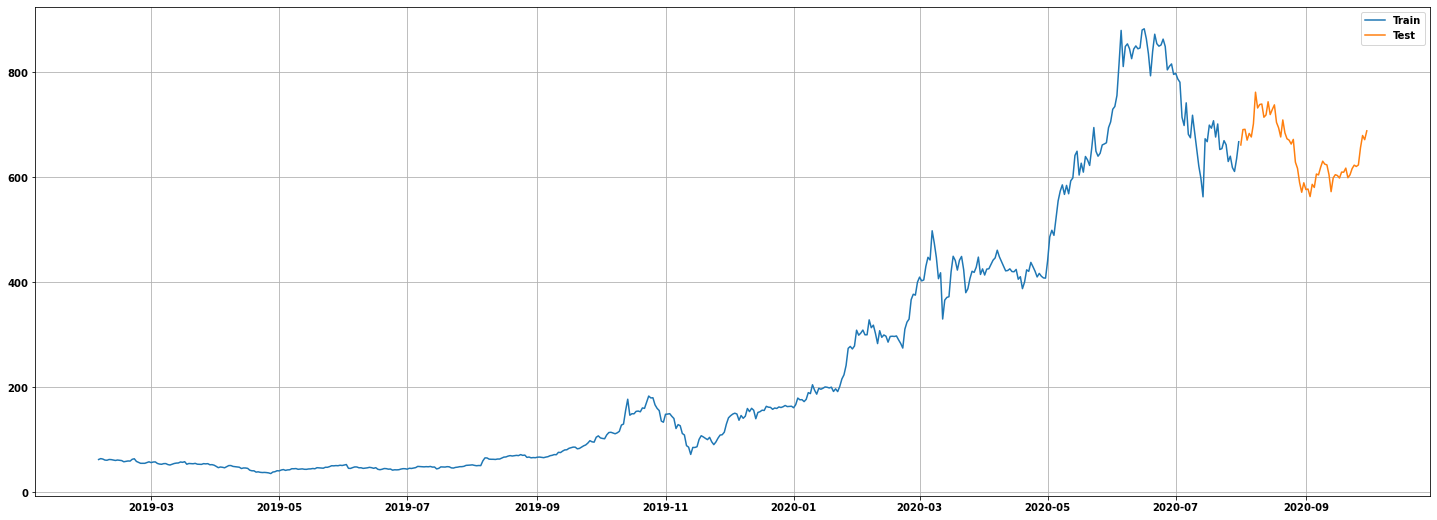

In [31]:
plt.plot(df_spend_train, label='Train')
plt.plot(df_spend_test, label='Test')
plt.legend(loc='best')
plt.grid()
plt.show()

### Building an ARIMA model

In [32]:
p = q = range(0, 4)
d = range(1, 2)
pdq = list(itertools.product(p, d, q))
print('''PDQ Combinations for the ARIMA model are:''')
for i in range(0, len(pdq)):
    print(f'PDQ: {pdq[i]}')

PDQ Combinations for the ARIMA model are:
PDQ: (0, 1, 0)
PDQ: (0, 1, 1)
PDQ: (0, 1, 2)
PDQ: (0, 1, 3)
PDQ: (1, 1, 0)
PDQ: (1, 1, 1)
PDQ: (1, 1, 2)
PDQ: (1, 1, 3)
PDQ: (2, 1, 0)
PDQ: (2, 1, 1)
PDQ: (2, 1, 2)
PDQ: (2, 1, 3)
PDQ: (3, 1, 0)
PDQ: (3, 1, 1)
PDQ: (3, 1, 2)
PDQ: (3, 1, 3)


In [33]:
df_aic_score = pd.DataFrame()

In [34]:
for param in pdq:
    try:
        mod_arima = ARIMA(endog=df_spend_train, order=param)
        mod_arima = mod_arima.fit()
        print(f'Params: {param}, AIC: {mod_arima.aic}')
        df_aic_score = df_aic_score.append({
            'Params': param, 
            'AIC': mod_arima.aic
        }, ignore_index=True)
        
    except:
        continue

Params: (0, 1, 0), AIC: 4519.383478542759
Params: (0, 1, 1), AIC: 4518.689274784909
Params: (0, 1, 2), AIC: 4520.53424845236
Params: (0, 1, 3), AIC: 4520.218807260002
Params: (1, 1, 0), AIC: 4518.8221436240765
Params: (1, 1, 1), AIC: 4520.636294389842
Params: (1, 1, 2), AIC: 4522.30955542998
Params: (1, 1, 3), AIC: 4522.0729839580845
Params: (2, 1, 0), AIC: 4520.27415947949
Params: (2, 1, 1), AIC: 4521.994414499566
Params: (2, 1, 3), AIC: 4496.126347633854
Params: (3, 1, 0), AIC: 4520.35747186249
Params: (3, 1, 1), AIC: 4521.879909433682
Params: (3, 1, 2), AIC: 4496.125392453636
Params: (3, 1, 3), AIC: 4494.695753679871


In [35]:
df_aic_score.sort_values(by='AIC')

,AIC,Params
14,4494.695754,"(3, 1, 3)"
13,4496.125392,"(3, 1, 2)"
10,4496.126348,"(2, 1, 3)"
1,4518.689275,"(0, 1, 1)"
4,4518.822144,"(1, 1, 0)"
0,4519.383479,"(0, 1, 0)"
3,4520.218807,"(0, 1, 3)"
8,4520.274159,"(2, 1, 0)"
11,4520.357472,"(3, 1, 0)"
2,4520.534248,"(0, 1, 2)"


In [36]:
mod_arima = ARIMA(df_spend_train, order=(3,1,3))
mod_arima = mod_arima.fit()
mod_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:         D.Avg spending   No. Observations:                  543
Model:                 ARIMA(3, 1, 3)   Log Likelihood               -2239.348
Method:                       css-mle   S.D. of innovations             14.867
Date:                Sat, 16 Apr 2022   AIC                           4494.696
Time:                        21:51:08   BIC                           4529.073
Sample:                    02-05-2019   HQIC                          4508.137
                         - 07-31-2020                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    1.1092      0.627      1.770      0.077      -0.119       2.337
ar.L1.D.Avg spending    -0.8295      0.014    -59.313      0.000      -0.857      -0.802
ar.L2.D.Avg spending    -0.7886      0.019    -41.939      0.000      -0.825      -0.752
ar.L3.D.Avg spending    -0.9537      0.014    -68.563      0.000      -0.981      -0.926
ma.L1.D.Avg spending     0.7528      0.013     58.710      0.000       0.728       0.778
ma.L2.D.Avg spending     0.7671      0.036     21.598      0.000       0.697       0.837
ma.L3.D.Avg spending     0.9884      0.040     24.656      0.000       0.910       1.067
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0025           -0.0000j            1.0025           -0.5000
AR.2            0.0878           -1.0189j            1.0227           -0.2363
AR.3            0.0878           +1.0189j            1.0227            0.2363
MA.1           -1.0117           -0.0000j            1.0117           -0.5000
MA.2            0.1178           -0.9930j            1.0000           -0.2312
MA.3            0.1178           +0.9930j            1.0000            0.2312
-----------------------------------------------------------------------------
"""

In [37]:
print('''Observation:
AR1, AR2, AR3 with first differential coeficients are -0.8295, -0.7886, -0.9537 with p-value < 0.5
Similarly MA1, MA2, MA3 with first differential coeficients are 0.7528, 0.7671, 0.9884 with p-value < 0.5.
So the model with Order p=3, d=1 and q=3 is stable
''')

Observation:
AR1, AR2, AR3 with first differential coeficients are -0.8295, -0.7886, -0.9537 with p-value < 0.5
Similarly MA1, MA2, MA3 with first differential coeficients are 0.7528, 0.7671, 0.9884 with p-value < 0.5.
So the model with Order p=3, d=1 and q=3 is stable



In [38]:
df_spend_test.shape

(61, 1)

In [40]:
forecast, stderr, conf_int = mod_arima.forecast(steps=len(df_spend_test), alpha=0.05)

In [41]:
forecast_series = pd.Series(forecast, index=df_spend_test.index)
conf_int_lower = pd.Series(conf_int[:, 0], index=df_spend_test.index)
conf_int_upper = pd.Series(conf_int[:, 1], index=df_spend_test.index)

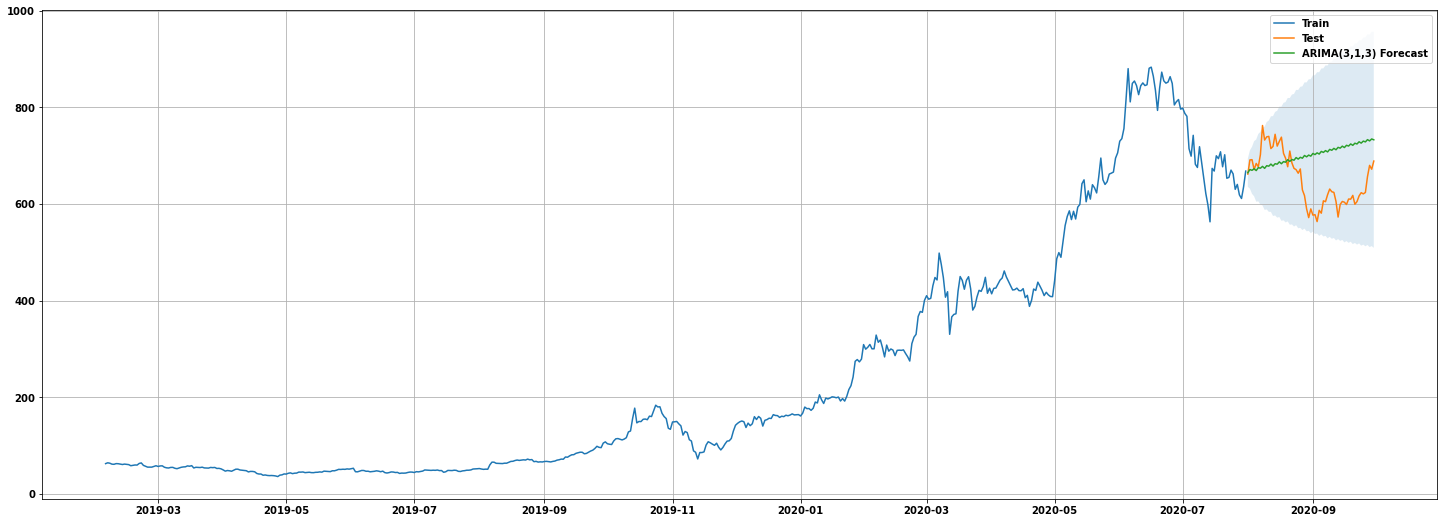

In [43]:
plt.plot(df_spend_train, label='Train')
plt.plot(df_spend_test, label='Test')
plt.plot(forecast_series, label='ARIMA(3,1,3) Forecast')
plt.fill_between(df_spend_test.index, conf_int_lower, conf_int_upper, alpha=0.15)
plt.legend(loc='best')
plt.grid()
plt.show()

##### Metrics

In [44]:
rmse_arima = mean_squared_error(y_true=df_spend_test['Avg spending'], y_pred=forecast, squared=False)
rmse_arima

84.30713970863938

In [45]:
def MAPE(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred)/y_true)*100

In [46]:
mape_arima = MAPE(y_true=df_spend_test['Avg spending'], y_pred=forecast)
mape_arima

11.66636805391642

### Building Hold Model

In [47]:
mod_des = Holt(df_spend_train, initialization_method='estimated')

In [48]:
mod_des = mod_des.fit(optimized=True)
mod_des.summary()

Dep. Variable:,Avg spending,No. Observations:,544
Model:,Holt,SSE,129299.585
Optimized:,True,AIC,2984.190
Trend:,Additive,BIC,3001.386
Seasonal:,None,AICC,2984.347
Seasonal Periods:,None,Date:,"Sat, 16 Apr 2022"
Box-Cox:,False,Time:,22:07:52
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9278529,alpha,True
smoothing_trend,2.9081e-06,beta,True


In [49]:
des_forecast = mod_des.forecast(len(df_spend_test))

In [50]:
des_forecast

2020-08-01    666.677201
2020-08-02    667.792077
2020-08-03    668.906952
2020-08-04    670.021828
2020-08-05    671.136704
                 ...    
2020-09-26    729.110252
2020-09-27    730.225128
2020-09-28    731.340004
2020-09-29    732.454880
2020-09-30    733.569756
Freq: D, Length: 61, dtype: float64

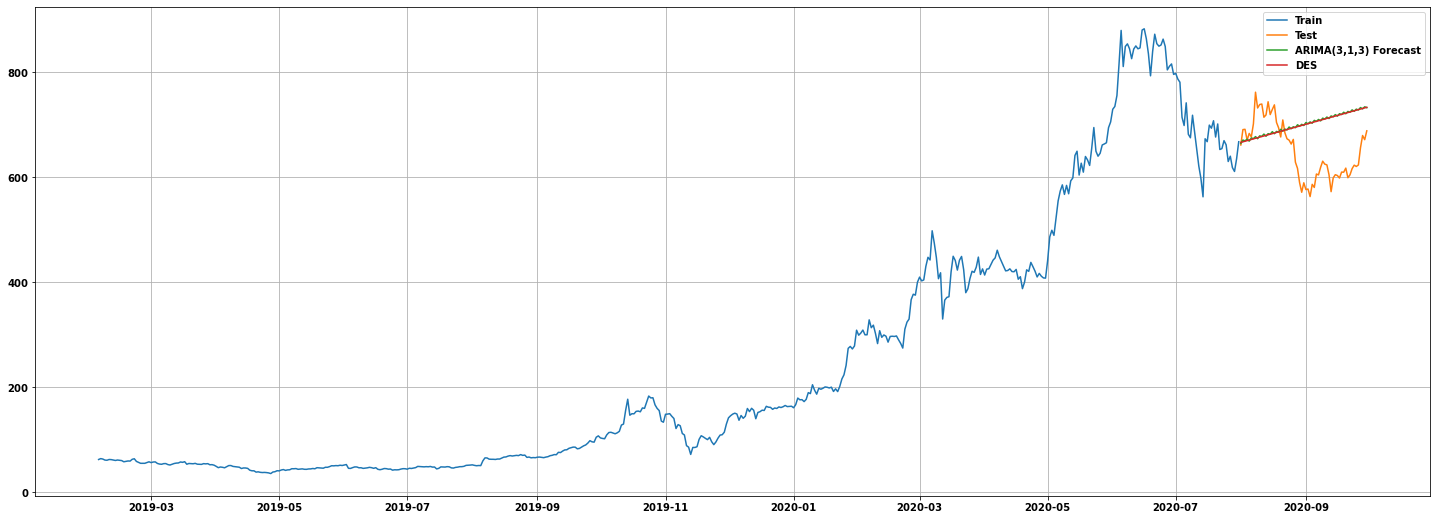

In [51]:
plt.plot(df_spend_train, label='Train')
plt.plot(df_spend_test, label='Test')
plt.plot(df_spend_test.index, forecast, label='ARIMA(3,1,3) Forecast')
plt.plot(df_spend_test.index, des_forecast, label='DES')
plt.legend(loc='best')
plt.grid()
plt.show()

In [52]:
rmse_des = mean_squared_error(y_true=df_spend_test['Avg spending'], y_pred=des_forecast, squared=False)
rmse_des

83.7599617854713

In [53]:
mape_des = MAPE(y_true=df_spend_test['Avg spending'], y_pred=des_forecast.values)
mape_des

11.60193040136403

##### Improve DES model

In [54]:
mod_des = Holt(df_spend_train, initialization_method='estimated')

In [55]:
mod_des = mod_des.fit(smoothing_level=0.9278529, smoothing_trend=2.9081e-06, optimized=False)

In [56]:
mod_des.summary()

Dep. Variable:,Avg spending,No. Observations:,544
Model:,Holt,SSE,130438.646
Optimized:,False,AIC,2988.962
Trend:,Additive,BIC,3006.157
Seasonal:,None,AICC,2989.118
Seasonal Periods:,None,Date:,"Sat, 16 Apr 2022"
Box-Cox:,False,Time:,22:08:56
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9278529,alpha,False
smoothing_trend,2.9081e-06,beta,False


In [57]:
des_forecast = mod_des.forecast(len(df_spend_test))

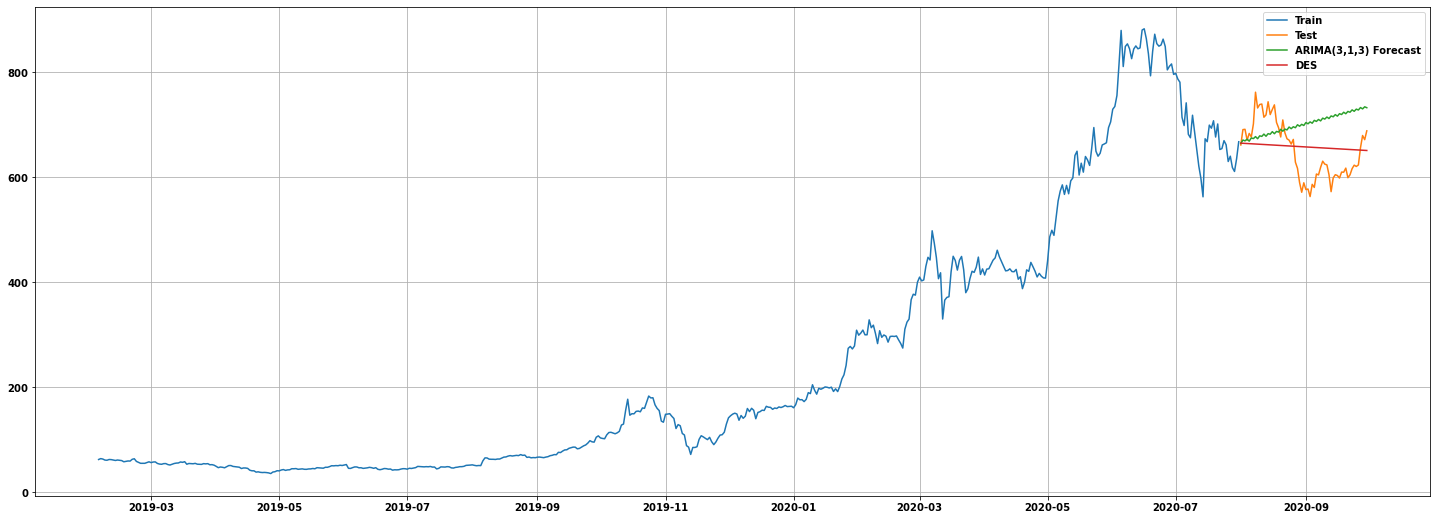

In [59]:
plt.plot(df_spend_train, label='Train')
plt.plot(df_spend_test, label='Test')
plt.plot(df_spend_test.index, forecast, label='ARIMA(3,1,3) Forecast')
plt.plot(df_spend_test.index, des_forecast, label='DES')
plt.legend(loc='best')
plt.grid()
plt.show()

In [60]:
rmse_des = mean_squared_error(y_true=df_spend_test['Avg spending'], y_pred=des_forecast, squared=False)
rmse_des

51.50179428034127

In [61]:
mape_des = MAPE(y_true=df_spend_test['Avg spending'], y_pred=des_forecast.values)
mape_des

7.075495772194007

In [62]:
print('''Both RMSE and MAPE values have decreased after fine tunning the model''')

Both RMSE and MAPE values have decreased after fine tunning the model


##### Analyzing the Residuals

In [63]:
residuals = df_spend_test['Avg spending'] - des_forecast
residuals

Date
2020-08-01    -3.475138
2020-08-02    26.057287
2020-08-03    26.859712
2020-08-04     6.442136
2020-08-05    19.504561
                ...    
2020-09-26   -28.499345
2020-09-27     4.593080
2020-09-28    28.075505
2020-09-29    20.357930
2020-09-30    37.440355
Freq: D, Length: 61, dtype: float64

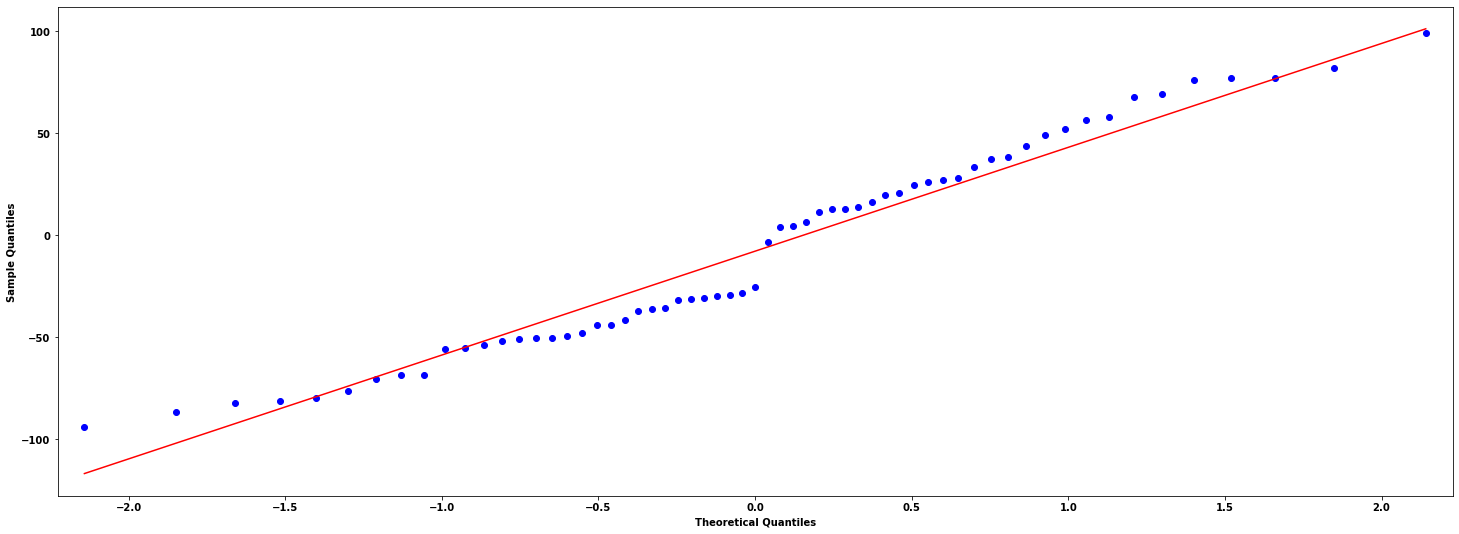

In [64]:
qqplot(residuals, line='s');
plt.show()

In [165]:
print('''Observation: q-q- plot confirms that residuals are normally distributed''')

Observation: q-q- plot confirms that residuals are normally distributed


##### Forcasting into the future

In [166]:
mod_des = Holt(df_spend, initialization_method='estimated')
mod_des = mod_des.fit(smoothing_level=0.9278529, smoothing_trend=2.9081e-06, optimized=False)
des_forecast = mod_des.forecast(30)
des_forecast

2020-10-01    687.285688
2020-10-02    687.053369
2020-10-03    686.821049
2020-10-04    686.588730
2020-10-05    686.356410
2020-10-06    686.124091
2020-10-07    685.891771
2020-10-08    685.659452
2020-10-09    685.427132
2020-10-10    685.194813
2020-10-11    684.962493
2020-10-12    684.730174
2020-10-13    684.497854
2020-10-14    684.265535
2020-10-15    684.033215
2020-10-16    683.800896
2020-10-17    683.568576
2020-10-18    683.336257
2020-10-19    683.103937
2020-10-20    682.871618
2020-10-21    682.639298
2020-10-22    682.406979
2020-10-23    682.174659
2020-10-24    681.942340
2020-10-25    681.710021
2020-10-26    681.477701
2020-10-27    681.245382
2020-10-28    681.013062
2020-10-29    680.780743
2020-10-30    680.548423
Freq: D, dtype: float64

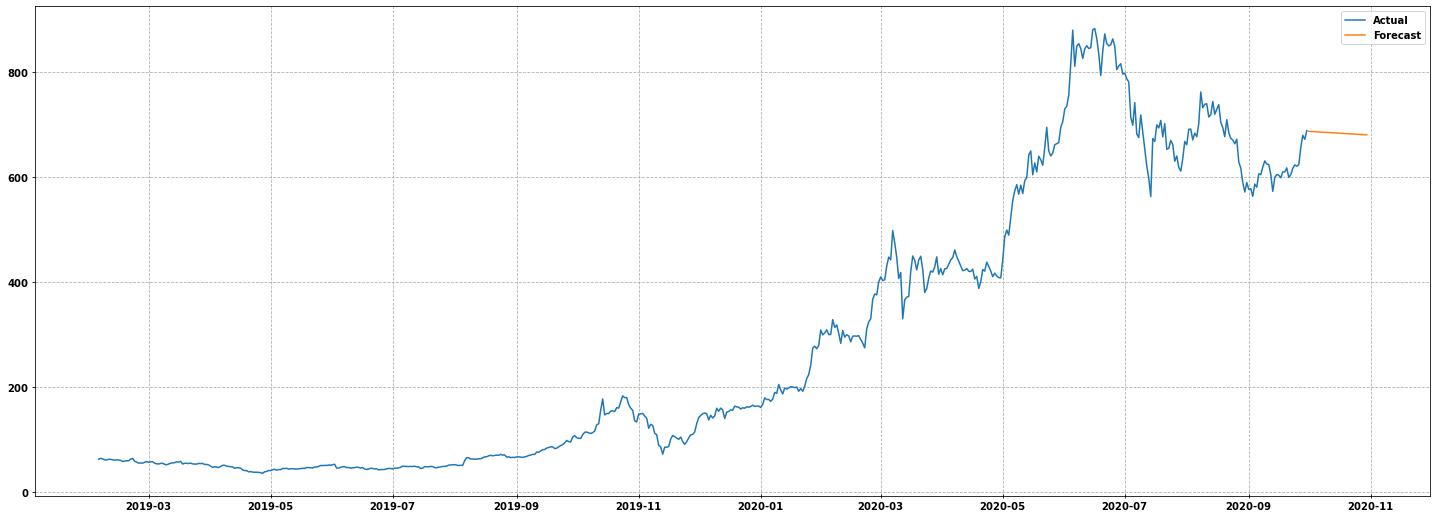

In [167]:
plt.plot(df_spend, label='Actual')
plt.plot(des_forecast, label='Forecast')
plt.legend(loc='best')
plt.grid()
plt.show()

# Data with Trend and Seasonality

In [39]:
plt.rcParams['figure.figsize'] = (25, 9)

In [31]:
df_AirPassengers = pd.read_csv('data/AirPassengers.csv')
df_AirPassengers.sample(2)

,Month,#Passengers
61,1954-02,188
31,1951-08,199


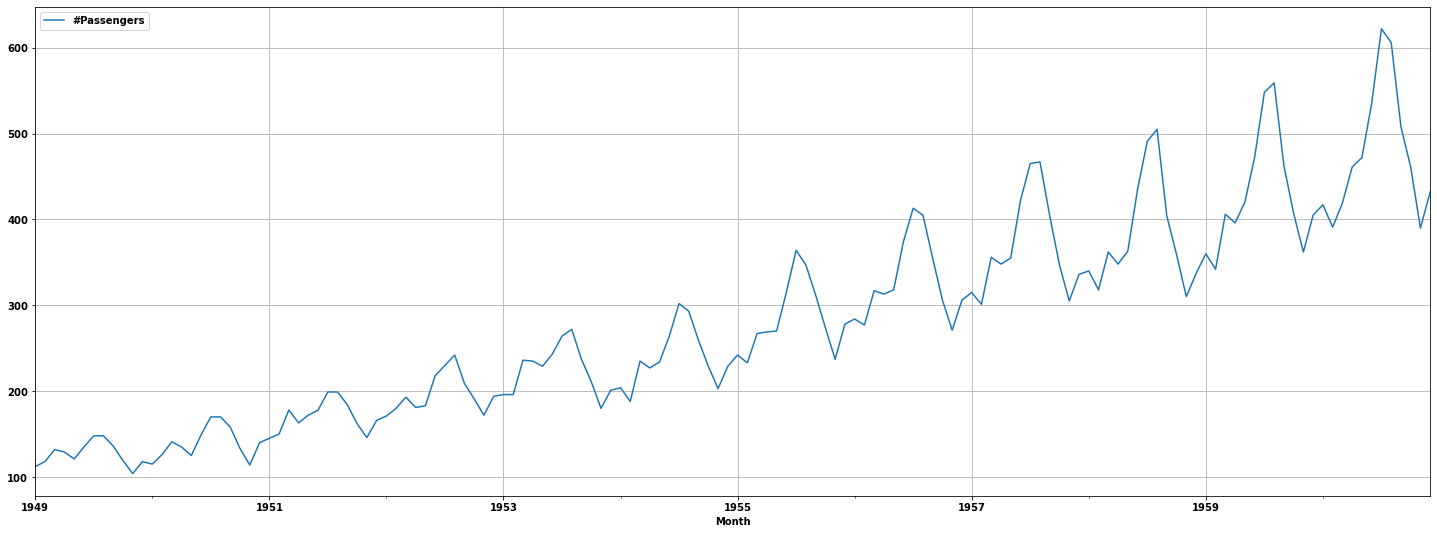

In [32]:
df_AirPassengers['Month'] = pd.to_datetime( df_AirPassengers['Month'])
df_AirPassengers.set_index(keys='Month', inplace=True)
df_AirPassengers.index.freq = 'MS'
df_AirPassengers.plot()
plt.grid(True)
plt.show()

In [33]:
df_AirPassengers.isnull().sum()

#Passengers    0
dtype: int64

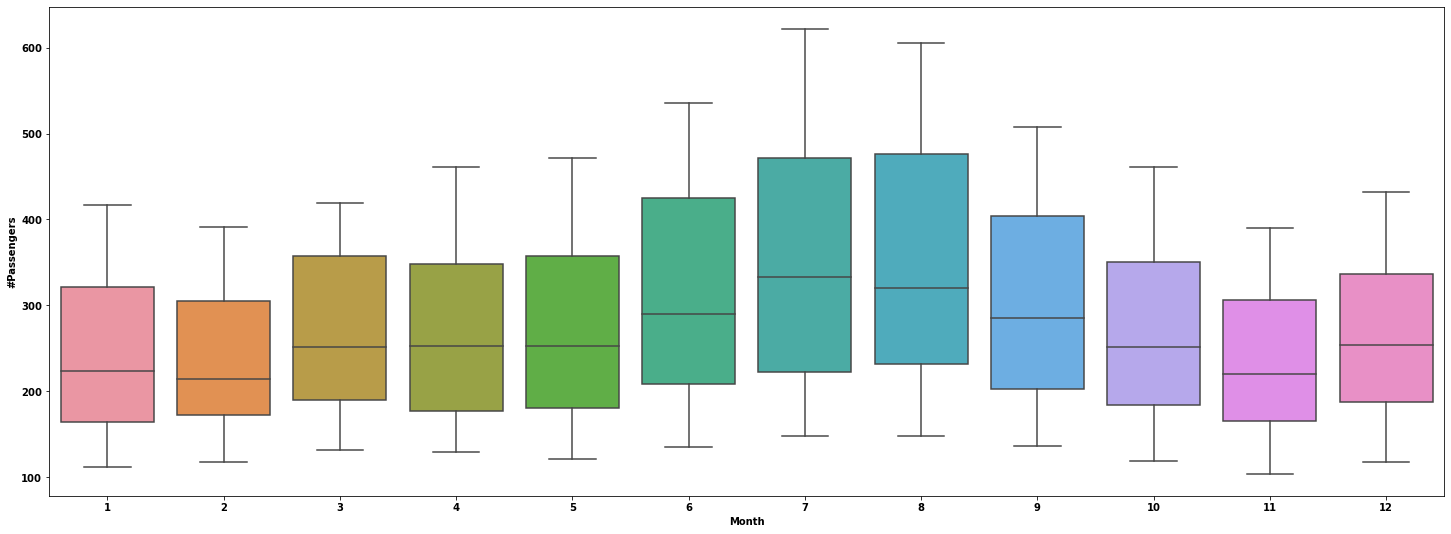

In [40]:
sns.boxplot(x=df_AirPassengers.index.month, y=df_AirPassengers['#Passengers'])
plt.show()

### Decomposition of Data

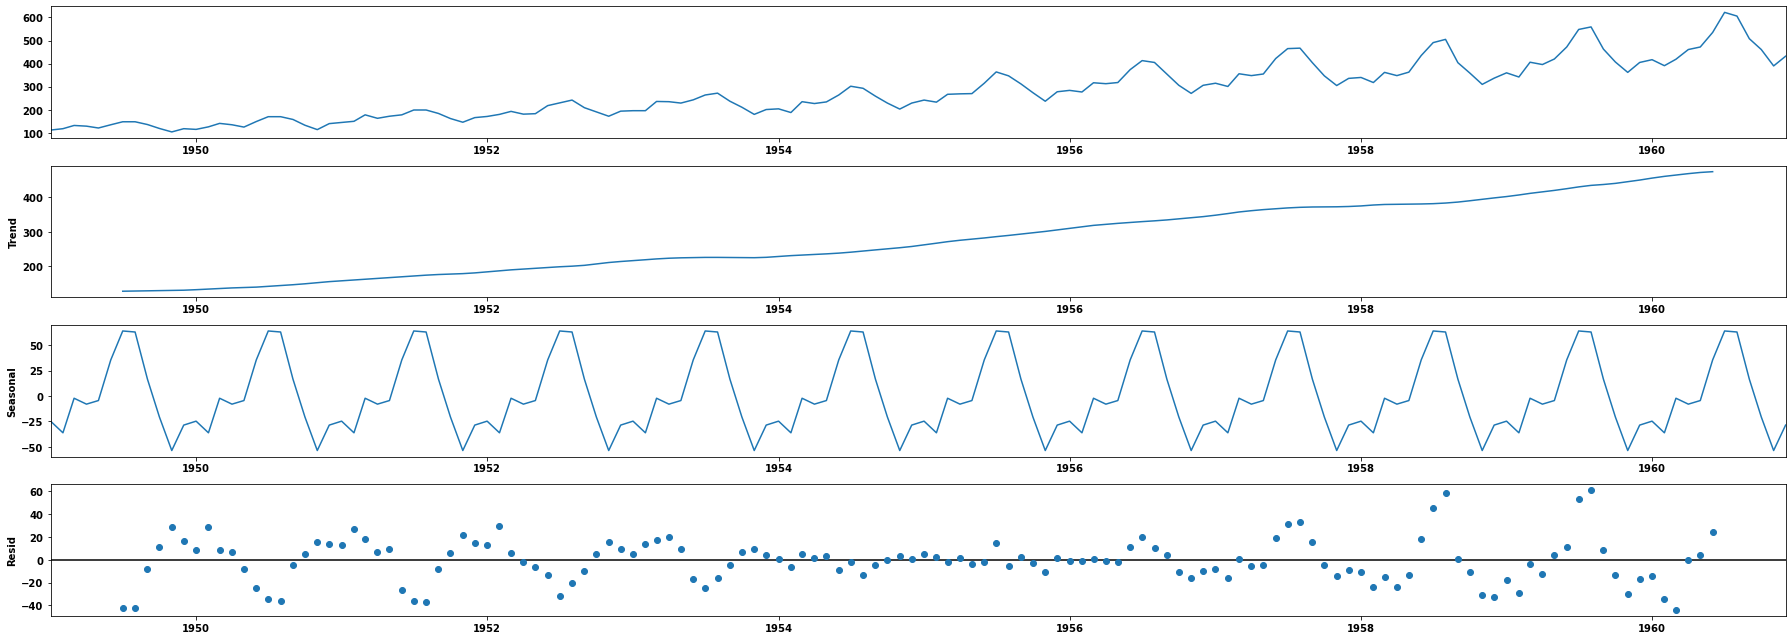

In [41]:
seasonal_decompose(x=df_AirPassengers, model='additive').plot();

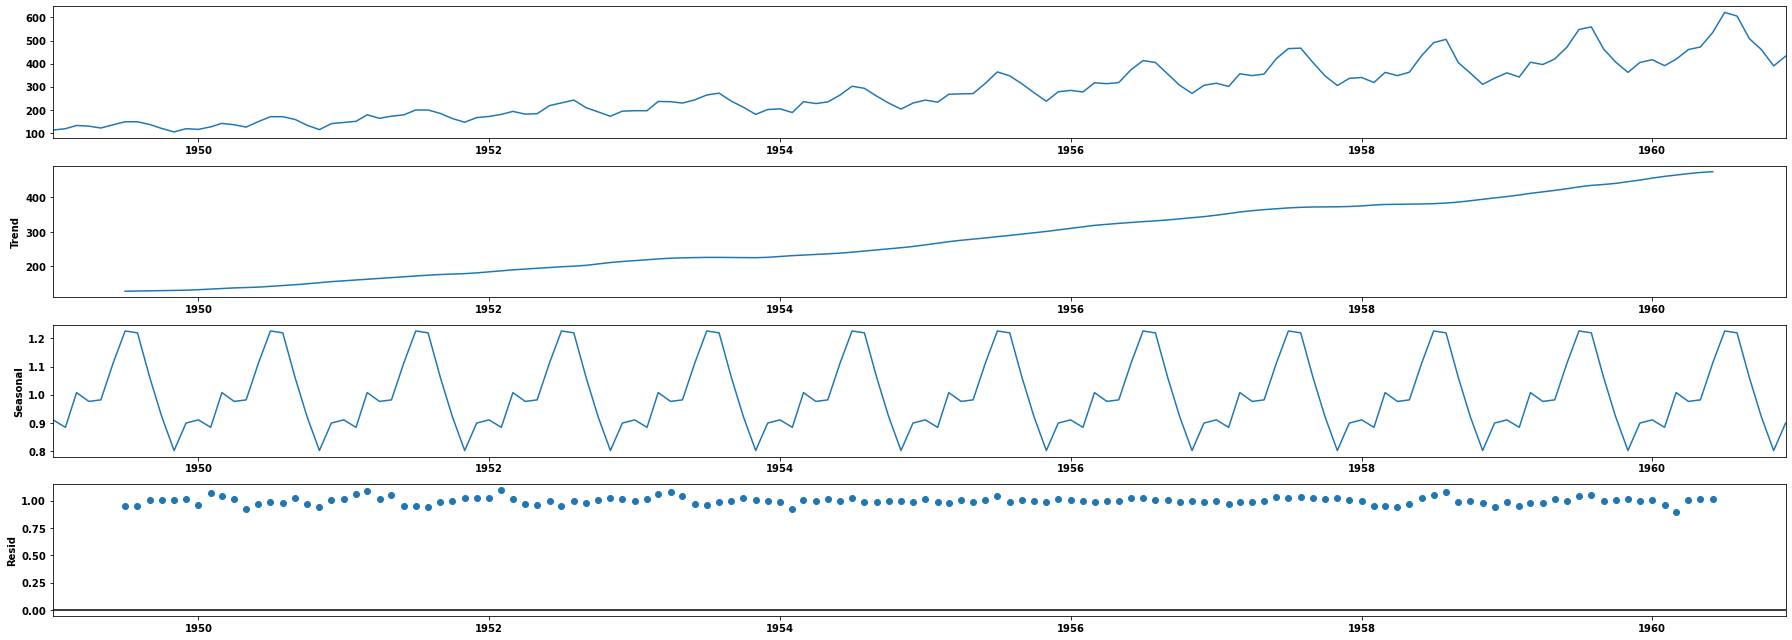

In [43]:
seasonal_decompose(x=df_AirPassengers, model='multiplicative').plot();

In [60]:
seasonal_decompose(x=df_AirPassengers, model='additive').resid.mean(), seasonal_decompose(x=df_AirPassengers, model='multiplicative').resid.mean() 

(-0.7512626262626092, 0.9982356582764101)

In [62]:
print(f'''
Observation: This is an multiplicative series since the seasonal variation does depend on Trend
Mean of Residue of Additive is not 0 ~ {seasonal_decompose(x=df_AirPassengers, model='additive').resid.mean()} 
where are for multiplicative its 1 ~  {seasonal_decompose(x=df_AirPassengers, model='multiplicative').resid.mean()}''')


Observation: This is an multiplicative series since the seasonal variation does depend on Trend
Mean of Residue of Additive is not 0 ~ -0.7512626262626092 
where are for multiplicative its 1 ~  0.9982356582764101


In [63]:
print('''Observation:
Decomposition plot shows that Trend component of time series is significant. 
Decomposition plot shows that there is seasonality in time series. 
Multiplicative Resdiuals are distributed with 0 mean.
Since we have Trend and Seasonality its better to use the Holt Winters Model (Triple Exponential Smoothing)''')

Observation:
Decomposition plot shows that Trend component of time series is significant. 
Decomposition plot shows that there is seasonality in time series. 
Multiplicative Resdiuals are distributed with 0 mean.
Since we have Trend and Seasonality its better to use the Holt Winters Model (Triple Exponential Smoothing)


In [65]:
adf_results = adfuller(df_AirPassengers.values)
print(f'''
ADF Statistic: {adf_results[0]}
p-Value: {adf_results[1]}
Critical Values:''')
for key, val in adf_results[4].items():
    print(f'\t{key}: {val}')


ADF Statistic: 0.8153688792060512
p-Value: 0.991880243437641
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [66]:
print('''
Observation: Test results confirms that the series is non-stationary at the confidence level of 99%. To make series stationary, will use differencing''')


Observation: Test results confirms that the series is non-stationary at the confidence level of 99%. To make series stationary, will use differencing


<AxesSubplot:xlabel='Month'>

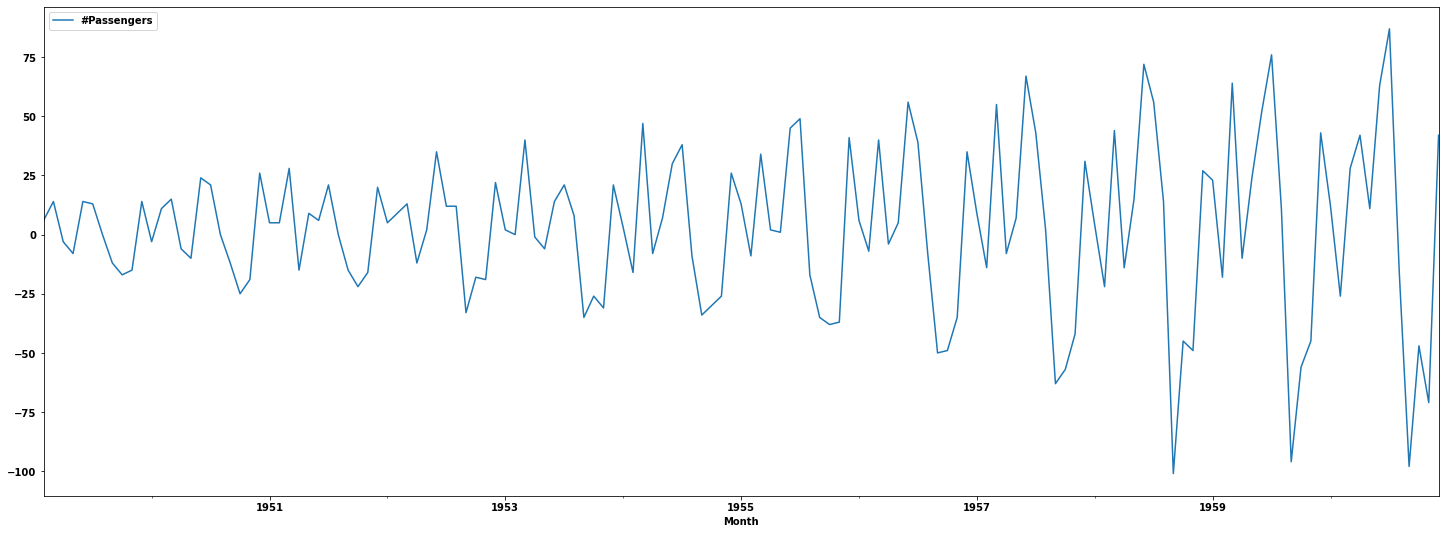

In [68]:
df_AirPassengers_diff1 = df_AirPassengers.diff().dropna()
df_AirPassengers_diff1.plot()

In [69]:
adf_results = adfuller(df_AirPassengers_diff1.values)
print(f'''
ADF Statistic: {adf_results[0]}
p-Value: {adf_results[1]}
Critical Values:''')
for key, val in adf_results[4].items():
    print(f'\t{key}: {val}')


ADF Statistic: -2.829266824169998
p-Value: 0.054213290283825676
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [ ]:
print('''
Observation: Test results confirms that the series is non-stationary at the confidence level of 99%. To make series stationary, will use differencing''')

<AxesSubplot:xlabel='Month'>

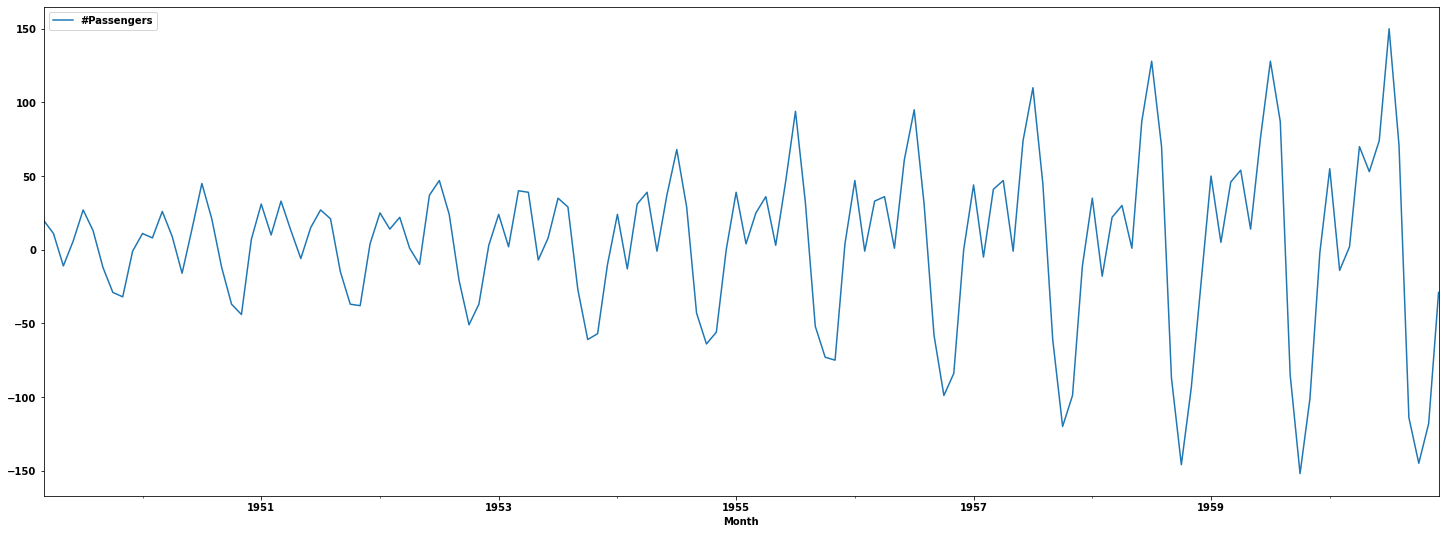

In [71]:
df_AirPassengers_diff2 = df_AirPassengers.diff(periods=2).dropna()
df_AirPassengers_diff2.plot()

In [72]:
adf_results = adfuller(df_AirPassengers_diff2.values)
print(f'''
ADF Statistic: {adf_results[0]}
p-Value: {adf_results[1]}
Critical Values:''')
for key, val in adf_results[4].items():
    print(f'\t{key}: {val}')


ADF Statistic: -2.9616951355554315
p-Value: 0.03862975767698765
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


In [78]:
print(f'''
Observation: Test results confirms that the series is stationary with p-Value: {adf_results[1]} which is < 0.05''')


Observation: Test results confirms that the series is stationary with p-Value: 0.03862975767698765 which is < 0.05


<Figure size 1800x2880 with 0 Axes>

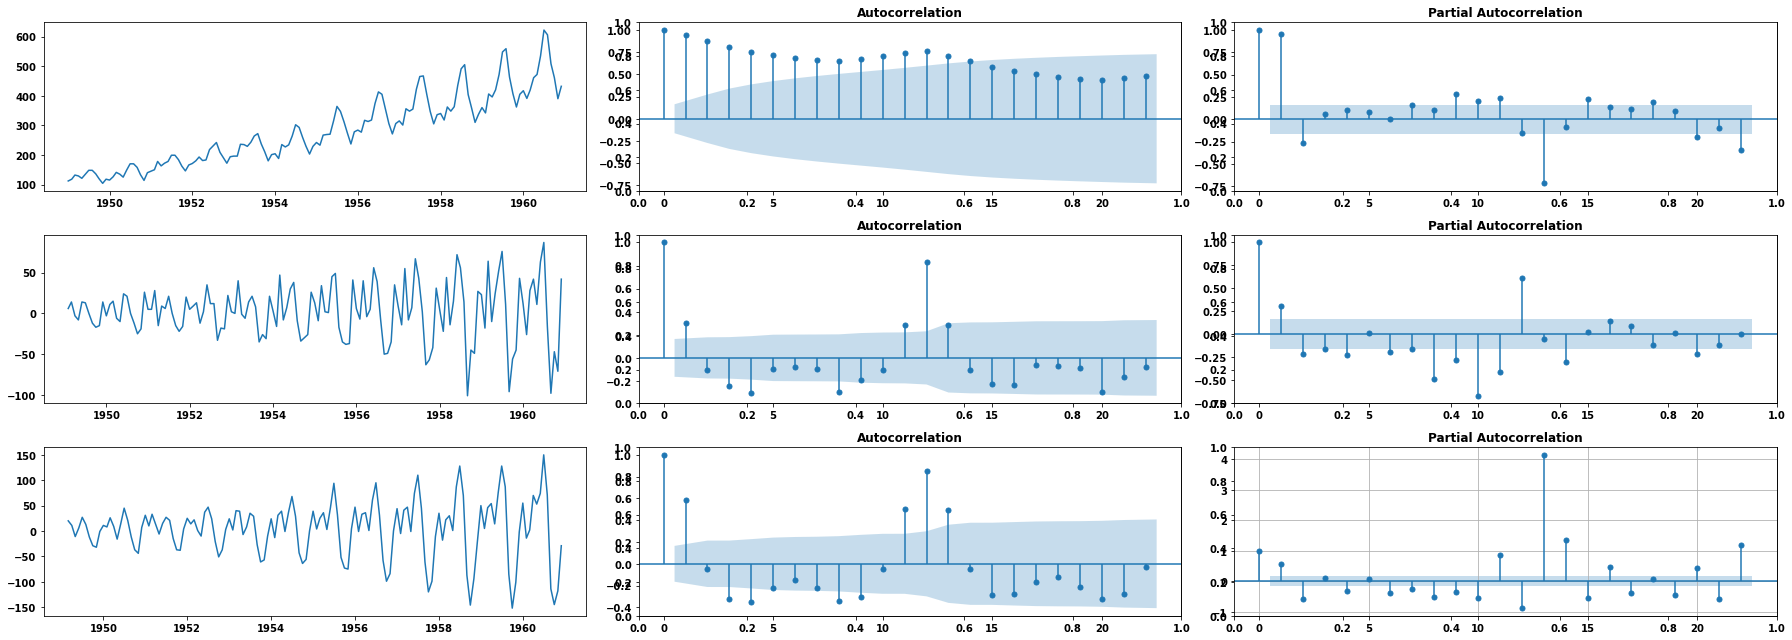

In [91]:
plt.figure(figsize=(25, 40))
fig, ax = plt.subplots(3, 3)

plt.subplot(3, 3, 1)
plt.plot(df_AirPassengers)
ax = fig.add_subplot(332)
plot_acf(df_AirPassengers, ax=ax)
ax = fig.add_subplot(333)
plot_pacf(df_AirPassengers, ax=ax)

plt.subplot(3, 3, 4)
plt.plot(df_AirPassengers_diff1)
ax = fig.add_subplot(335)
plot_acf(df_AirPassengers_diff1, ax=ax)
ax = fig.add_subplot(336)
plot_pacf(df_AirPassengers_diff1, ax=ax)

plt.subplot(3, 3, 7)
plt.plot(df_AirPassengers_diff2)
ax = fig.add_subplot(338)
plot_acf(df_AirPassengers_diff2, ax=ax)
ax = fig.add_subplot(339)
plot_pacf(df_AirPassengers_diff2, ax=ax)

plt.tight_layout()
plt.grid(True)
plt.show()

In [92]:
print('''Observation: Based on ACF and PACF plot
Autocorrelation (ACF) is Geometically decreasing
where as PACF is significant till q=2 and then its insignificant. 
So model parameters are AR(2 or more), MA(2) (i.e., p=2) and d=2''')

Observation: Based on ACF and PACF plot
Autocorrelation (ACF) is Geometically decreasing
where as PACF is significant till q=2 and then its insignificant. 
So model parameters are AR(2 or more), MA(2) (i.e., p=2) and d=2


### Model Building

In [96]:
df_AirPassengers_train = df_AirPassengers[:120]
df_AirPassengers_test = df_AirPassengers[120:]

In [97]:
df_AirPassengers_train.tail()

,#Passengers
Month,
1958-08-01,505
1958-09-01,404
1958-10-01,359
1958-11-01,310
1958-12-01,337


In [98]:
df_AirPassengers_test.head()

,#Passengers
Month,
1959-01-01,360
1959-02-01,342
1959-03-01,406
1959-04-01,396
1959-05-01,420


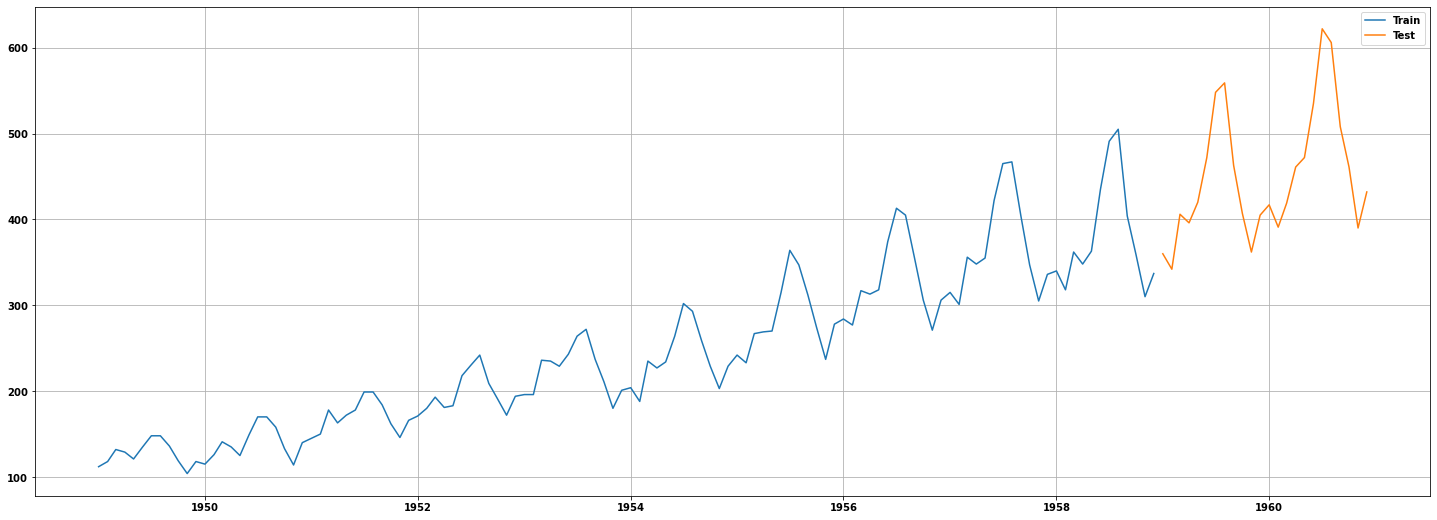

In [99]:
plt.plot(df_AirPassengers_train, label='Train')
plt.plot(df_AirPassengers_test, label='Test')
plt.legend(loc='best')
plt.grid()
plt.show()

In [100]:
p = range(0, 4)
q = range(0, 3)
d = range(0, 2)

In [106]:
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(p, d, q)]

In [107]:
df_aic_score = pd.DataFrame()

In [108]:
for param in pdq:
    for param_seasonal in model_pdq:
        mod_sarima = SARIMAX(endog=df_AirPassengers, order=param, seasonal_order=param_seasonal, 
                             enforce_stationarity=False, enforce_invertibility=False)
        mod_sarima = mod_sarima.fit()
        print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, mod_sarima.aic))
        df_aic_score = df_aic_score.append({
            'param':param,
            'seasonal':param_seasonal,
            'AIC': mod_sarima.aic
        }, ignore_index=True)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2044.4329486427587
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1887.307319153203
SARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:1498.2861800752999
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:1315.9211929474204
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1156.2914901508539
SARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:1016.1362797336836
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:1118.6259190717344
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1107.2562043232965
SARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:1014.6452265991207
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1109.2437994445115
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1033.6172166729584
SARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:904.4213211128697
SARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:1024.7669132306019
SARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:1020.065082718486
SARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:1014.0110804053737
SARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:976.4373805907877
SARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:934.9124902575488
SARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AI

SARIMA(1, 0, 0)x(0, 0, 2, 12)12 - AIC:1056.8694828967211
SARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:1029.9773091701022
SARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:944.385492153314
SARIMA(1, 0, 0)x(0, 1, 2, 12)12 - AIC:856.9391561803591
SARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1017.315549357125
SARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1007.0272556231284
SARIMA(1, 0, 0)x(1, 0, 2, 12)12 - AIC:925.0288685671978
SARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:944.0441660823766
SARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:945.4400866847378
SARIMA(1, 0, 0)x(1, 1, 2, 12)12 - AIC:849.22140171704
SARIMA(1, 0, 0)x(2, 0, 0, 12)12 - AIC:926.7587662622748
SARIMA(1, 0, 0)x(2, 0, 1, 12)12 - AIC:926.3936194941065
SARIMA(1, 0, 0)x(2, 0, 2, 12)12 - AIC:925.8761432076445
SARIMA(1, 0, 0)x(2, 1, 0, 12)12 - AIC:856.705695230893
SARIMA(1, 0, 0)x(2, 1, 1, 12)12 - AIC:857.2179252757203
SARIMA(1, 0, 0)x(2, 1, 2, 12)12 - AIC:857.4975315454448
SARIMA(1, 0, 0)x(3, 0, 0, 12)12 - AIC:838.9853021239429
SARIMA(1, 0, 0)x(3, 0, 1, 12)12 - AIC:840.5771949

SARIMA(2, 0, 0)x(0, 1, 2, 12)12 - AIC:848.3993498533697
SARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:1001.3123373211381
SARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:989.3302334105638
SARIMA(2, 0, 0)x(1, 0, 2, 12)12 - AIC:917.4819661819272
SARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:928.3021928980603
SARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:934.7862613236255
SARIMA(2, 0, 0)x(1, 1, 2, 12)12 - AIC:839.9515647055817
SARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:907.2206391700257
SARIMA(2, 0, 0)x(2, 0, 1, 12)12 - AIC:908.8873125046202
SARIMA(2, 0, 0)x(2, 0, 2, 12)12 - AIC:908.5605032639202
SARIMA(2, 0, 0)x(2, 1, 0, 12)12 - AIC:840.5569263651674
SARIMA(2, 0, 0)x(2, 1, 1, 12)12 - AIC:839.1558500664258
SARIMA(2, 0, 0)x(2, 1, 2, 12)12 - AIC:838.6359381322351
SARIMA(2, 0, 0)x(3, 0, 0, 12)12 - AIC:823.6940061291765
SARIMA(2, 0, 0)x(3, 0, 1, 12)12 - AIC:825.693676041951
SARIMA(2, 0, 0)x(3, 0, 2, 12)12 - AIC:825.8150684511672
SARIMA(2, 0, 0)x(3, 1, 0, 12)12 - AIC:752.0680923355428
SARIMA(2, 0, 0)x(3, 1, 1, 12)12 - AIC:753.067497

SARIMA(3, 0, 0)x(1, 0, 2, 12)12 - AIC:917.3534434581138
SARIMA(3, 0, 0)x(1, 1, 0, 12)12 - AIC:922.4280801312877
SARIMA(3, 0, 0)x(1, 1, 1, 12)12 - AIC:928.9789439421337
SARIMA(3, 0, 0)x(1, 1, 2, 12)12 - AIC:840.9995425819754
SARIMA(3, 0, 0)x(2, 0, 0, 12)12 - AIC:900.77979607516
SARIMA(3, 0, 0)x(2, 0, 1, 12)12 - AIC:902.5554489118139
SARIMA(3, 0, 0)x(2, 0, 2, 12)12 - AIC:901.0605658782945
SARIMA(3, 0, 0)x(2, 1, 0, 12)12 - AIC:834.6984993564013
SARIMA(3, 0, 0)x(2, 1, 1, 12)12 - AIC:831.3697071595443
SARIMA(3, 0, 0)x(2, 1, 2, 12)12 - AIC:831.7658228229408
SARIMA(3, 0, 0)x(3, 0, 0, 12)12 - AIC:817.2969107243513
SARIMA(3, 0, 0)x(3, 0, 1, 12)12 - AIC:819.191748780108
SARIMA(3, 0, 0)x(3, 0, 2, 12)12 - AIC:819.9306977020459
SARIMA(3, 0, 0)x(3, 1, 0, 12)12 - AIC:744.0411824467234
SARIMA(3, 0, 0)x(3, 1, 1, 12)12 - AIC:740.0766475966062
SARIMA(3, 0, 0)x(3, 1, 2, 12)12 - AIC:740.3292723466003
SARIMA(3, 0, 1)x(0, 0, 0, 12)12 - AIC:1381.040356124247
SARIMA(3, 0, 1)x(0, 0, 1, 12)12 - AIC:1166.63567212

In [109]:
df_aic_score.sort_values(by='AIC')

,AIC,param,seasonal
527,732.934009,"(3, 1, 0)","(3, 1, 2, 12)"
575,733.137956,"(3, 1, 2)","(3, 1, 2, 12)"
549,734.425318,"(3, 1, 1)","(3, 1, 0, 12)"
551,734.915349,"(3, 1, 1)","(3, 1, 2, 12)"
525,735.773238,"(3, 1, 0)","(3, 1, 0, 12)"
...,...,...,...
25,1567.991631,"(0, 0, 1)","(0, 0, 1, 12)"
48,1702.388046,"(0, 0, 2)","(0, 0, 0, 12)"
24,1846.078938,"(0, 0, 1)","(0, 0, 0, 12)"
1,1887.307319,"(0, 0, 0)","(0, 0, 1, 12)"


In [110]:
mod_sarima = SARIMAX(df_AirPassengers_train, 
                    order=(3, 1, 0), seasonal_order=(3, 1, 2, 12),
                    enforce_stationarity=False, enforce_invertibility=False)

mod_sarima = mod_sarima.fit()
mod_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                             #Passengers   No. Observations:                  120
Model:             SARIMAX(3, 1, 0)x(3, 1, [1, 2], 12)   Log Likelihood                -250.295
Date:                                 Sun, 17 Apr 2022   AIC                            518.590
Time:                                         06:32:09   BIC                            538.566
Sample:                                     01-01-1949   HQIC                           526.505
                                          - 12-01-1958                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4363      0.143     -3.047      0.002      -0.717      -0.156
ar.L2         -0.0577      0.156     -0.370      0.711      -0.363       0.248
ar.L3          0.0939      0.145      0.648      0.517      -0.190       0.378
ar.S.L12       0.1877      0.221      0.850      0.395      -0.245       0.620
ar.S.L24       0.6792      0.141      4.822      0.000       0.403       0.955
ar.S.L36       0.2438      0.204      1.194      0.233      -0.157       0.644
ma.S.L12      -0.2619   4104.260  -6.38e-05      1.000   -8044.464    8043.941
ma.S.L24      -0.7382   3029.575     -0.000      1.000   -5938.597    5937.120
sigma2        69.4669   2.85e+05      0.000      1.000   -5.59e+05    5.59e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.74   Prob(JB):                         1.00
Heteroskedasticity (H):               0.82   Skew:                            -0.01
Prob(H) (two-sided):                  0.64   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [111]:
mod_sarima = SARIMAX(df_AirPassengers_train, 
                    order=(3, 1, 2), seasonal_order=(3, 1, 2, 12),
                    enforce_stationarity=False, enforce_invertibility=False)

mod_sarima = mod_sarima.fit()
mod_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        #Passengers   No. Observations:                  120
Model:             SARIMAX(3, 1, 2)x(3, 1, 2, 12)   Log Likelihood                -246.540
Date:                            Sun, 17 Apr 2022   AIC                            515.081
Time:                                    06:33:13   BIC                            539.495
Sample:                                01-01-1949   HQIC                           524.754
                                     - 12-01-1958                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1189      0.152      0.783      0.434      -0.179       0.417
ar.L2         -0.5922      0.137     -4.317      0.000      -0.861      -0.323
ar.L3         -0.2596      0.120     -2.166      0.030      -0.495      -0.025
ma.L1         -0.3440    138.599     -0.002      0.998    -271.994     271.306
ma.L2          1.0000    805.752      0.001      0.999   -1578.245    1580.245
ar.S.L12       0.0451      0.248      0.182      0.856      -0.441       0.531
ar.S.L24       0.0078      0.180      0.043      0.966      -0.345       0.361
ar.S.L36       0.0926      0.094      0.986      0.324      -0.091       0.277
ma.S.L12       0.2127      0.310      0.686      0.493      -0.395       0.820
ma.S.L24       0.1101      0.266      0.414      0.679      -0.412       0.632
sigma2        73.7698   5.94e+04      0.001      0.999   -1.16e+05    1.17e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.11   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.73   Prob(JB):                         0.83
Heteroskedasticity (H):               1.20   Skew:                            -0.09
Prob(H) (two-sided):                  0.66   Kurtosis:                         2.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [112]:
forecast_sarima = mod_sarima.forecast(steps=len(df_AirPassengers_test))
forecast_sarima

1959-01-01    343.409015
1959-02-01    314.534755
1959-03-01    355.172125
1959-04-01    340.220871
1959-05-01    360.172350
1959-06-01    434.443306
1959-07-01    491.525078
1959-08-01    508.964507
1959-09-01    397.546821
1959-10-01    355.822275
1959-11-01    304.643523
1959-12-01    328.850468
1960-01-01    335.538647
1960-02-01    304.512734
1960-03-01    344.767926
1960-04-01    328.854792
1960-05-01    350.208501
1960-06-01    425.688410
1960-07-01    484.586600
1960-08-01    504.181712
1960-09-01    387.149171
1960-10-01    346.607485
1960-11-01    294.083004
1960-12-01    317.370621
Freq: MS, Name: predicted_mean, dtype: float64

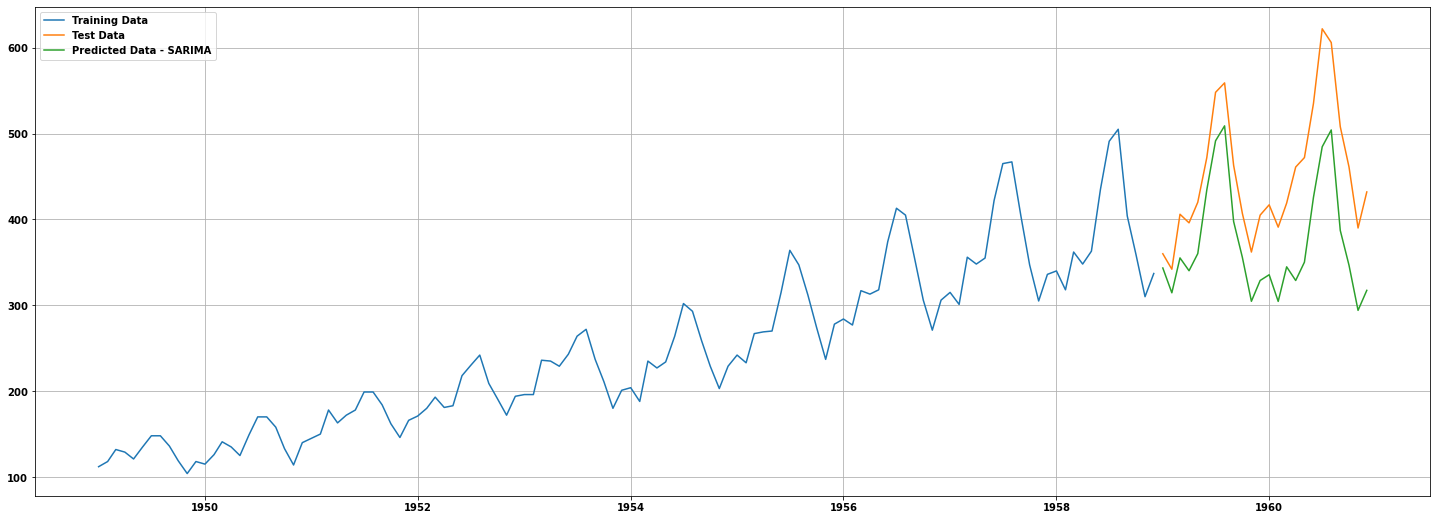

In [113]:
plt.plot(df_AirPassengers_train,label='Training Data')
plt.plot(df_AirPassengers_test,label='Test Data')
plt.plot(df_AirPassengers_test.index,forecast_sarima,label='Predicted Data - SARIMA')
plt.legend(loc='best')
plt.grid();

In [115]:
rmse_sarima = mean_squared_error(y_true=df_AirPassengers_test, y_pred=forecast_sarima, squared=False)
rmse_sarima

85.76855731639981

In [127]:
def MAPE(y_true, y_pred):
    return np.mean((np.abs(y_true - y_pred))/(y_true))

In [128]:
MAPE(df_AirPassengers_test['#Passengers'], y_pred=forecast_sarima.values)

0.17289900047294768

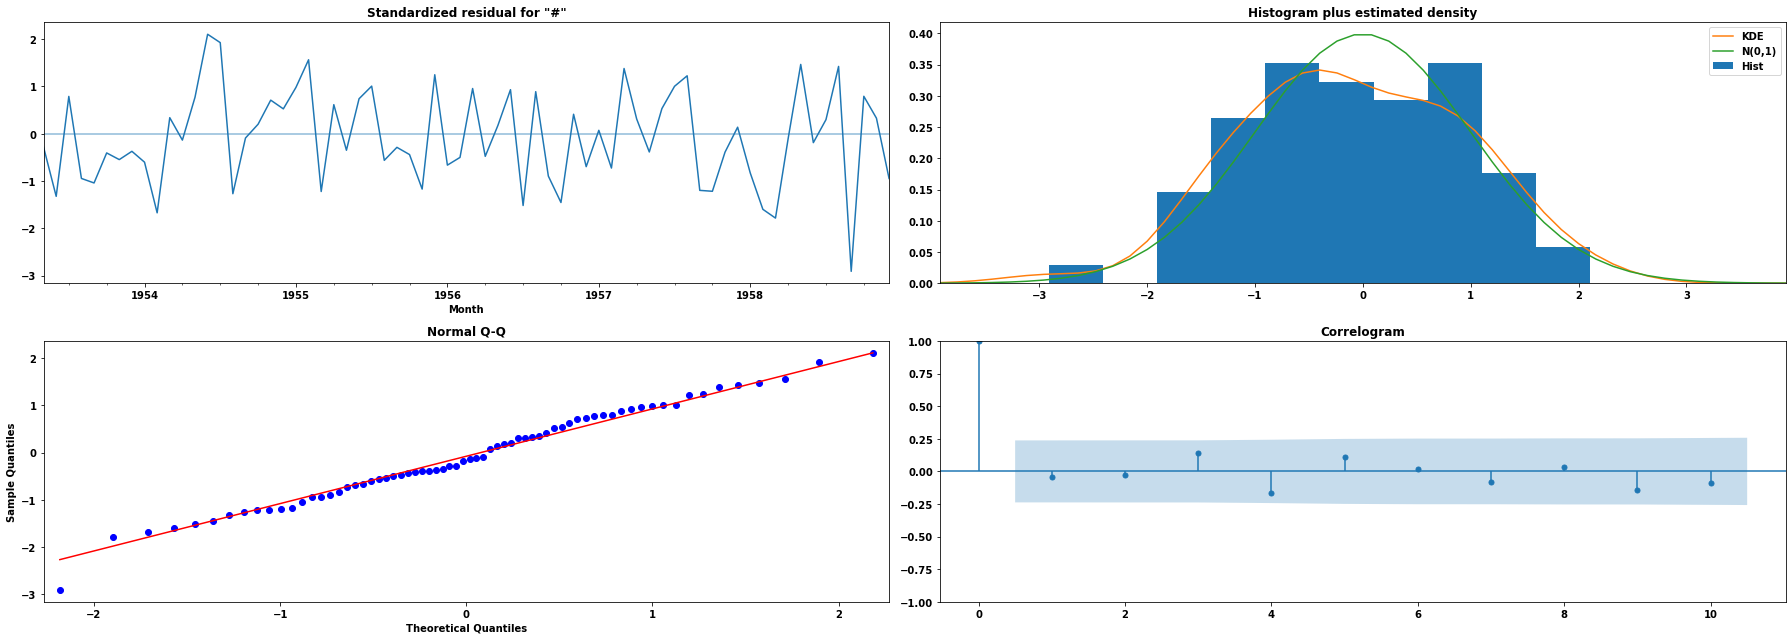

In [134]:
mod_sarima.plot_diagnostics();
plt.tight_layout()
plt.show()

### Model Hold Winters

In [135]:
mod_tes = ExponentialSmoothing(endog=df_AirPassengers, trend='additive',
                              seasonal='multiplicative', initialization_method='estimated')

In [136]:
mod_tes = mod_tes.fit()
mod_tes.summary()

Dep. Variable:,#Passengers,No. Observations:,144
Model:,ExponentialSmoothing,SSE,15952.885
Optimized:,True,AIC,709.892
Trend:,Additive,BIC,757.409
Seasonal:,Multiplicative,AICC,715.364
Seasonal Periods:,12,Date:,"Sun, 17 Apr 2022"
Box-Cox:,False,Time:,06:47:59
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3185436,alpha,True
smoothing_trend,1.9427e-07,beta,True


In [137]:
forecast_tes = mod_tes.forecast(len(df_AirPassengers_test))
forecast_tes

1961-01-01    445.243672
1961-02-01    418.226795
1961-03-01    465.313688
1961-04-01    494.949772
1961-05-01    505.476830
1961-06-01    573.315096
1961-07-01    663.597469
1961-08-01    654.905853
1961-09-01    546.760868
1961-10-01    488.445875
1961-11-01    415.724391
1961-12-01    460.378848
1962-01-01    474.073185
1962-02-01    445.161630
1962-03-01    495.121063
1962-04-01    526.487240
1962-05-01    537.514949
1962-06-01    609.462016
1962-07-01    705.217922
1962-08-01    695.767604
1962-09-01    580.698636
1962-10-01    518.607982
1962-11-01    441.264434
1962-12-01    488.518177
Freq: MS, dtype: float64

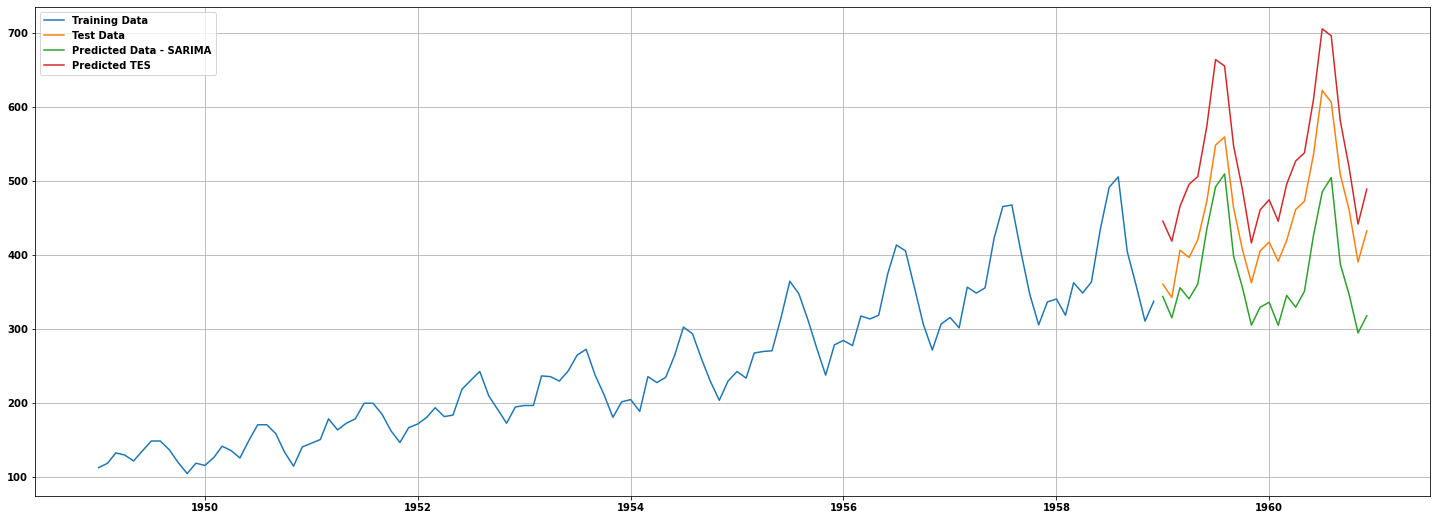

In [138]:
plt.plot(df_AirPassengers_train,label='Training Data')
plt.plot(df_AirPassengers_test,label='Test Data')
plt.plot(df_AirPassengers_test.index,forecast_sarima,label='Predicted Data - SARIMA')
plt.plot(df_AirPassengers_test.index, forecast_tes, label='Predicted TES')
plt.legend(loc='best')
plt.grid();

##### Tuning TES

In [139]:
mod_tes = ExponentialSmoothing(endog=df_AirPassengers, trend='additive',
                              seasonal='multiplicative', initialization_method='estimated')
mod_tes = mod_tes.fit(smoothing_level=0.3185436,smoothing_trend=1.9427e-07, smoothing_seasonal=0.6012910)
mod_tes.summary()

Dep. Variable:,#Passengers,No. Observations:,144
Model:,ExponentialSmoothing,SSE,15952.885
Optimized:,True,AIC,709.892
Trend:,Additive,BIC,757.409
Seasonal:,Multiplicative,AICC,715.364
Seasonal Periods:,12,Date:,"Sun, 17 Apr 2022"
Box-Cox:,False,Time:,06:52:25
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.3185436,alpha,False
smoothing_trend,1.9427e-07,beta,False


In [140]:
forecast_tes = mod_tes.forecast(len(df_AirPassengers_test))

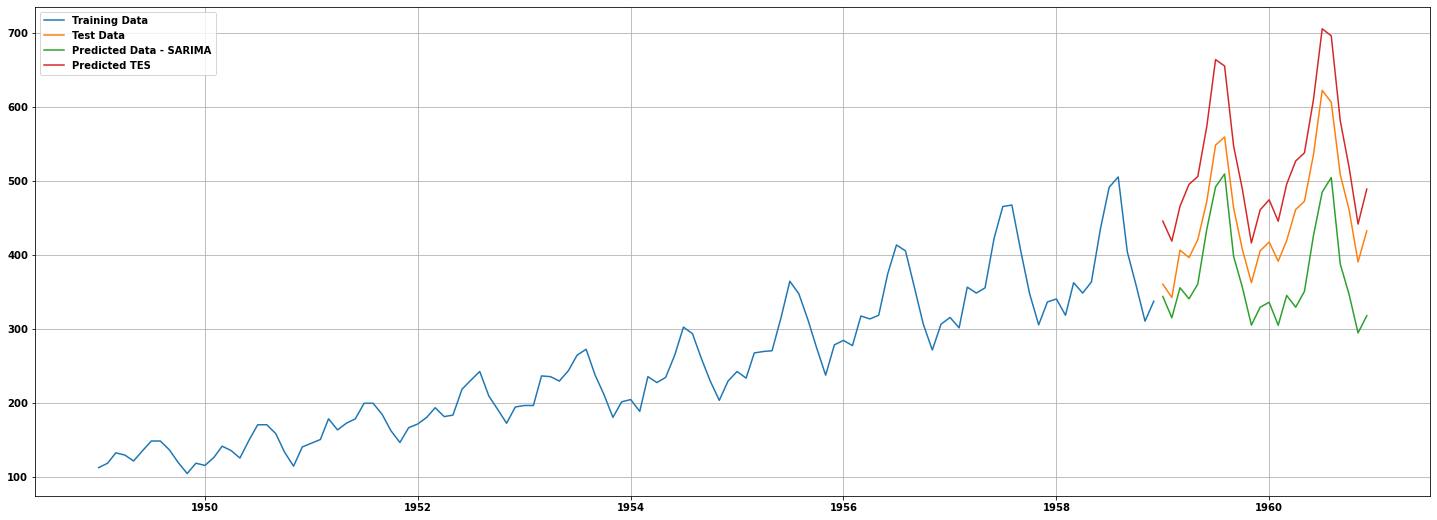

In [141]:
plt.plot(df_AirPassengers_train,label='Training Data')
plt.plot(df_AirPassengers_test,label='Test Data')
plt.plot(df_AirPassengers_test.index,forecast_sarima,label='Predicted Data - SARIMA')
plt.plot(df_AirPassengers_test.index, forecast_tes, label='Predicted TES')
plt.legend(loc='best')
plt.grid();

In [142]:
rmse_tes = mean_squared_error(df_AirPassengers_test,forecast_tes, squared=False)
print(rmse_tes)

76.82180837271588


In [144]:
MAPE(df_AirPassengers_test['#Passengers'], forecast_tes.values)

0.1671591767572714

# Other data

In [9]:
df_min_temp = pd.read_csv('data/daily-min-temperatures.csv')
df_min_temp.sample(2)

,Date,Temp
2674,1988-04-29,14.3
244,1981-09-02,10.3


In [11]:
df_tractor_sales = pd.read_csv('data/TractorSales.csv')
df_tractor_sales.sample(2)

,Month-Year,Number of Tractor Sold
73,9-Feb,310
0,3-Jan,141


In [12]:
df_shampoo_sales = pd.read_csv('data/shampoo_sales.csv')
df_shampoo_sales.sample(2)

,Month,Sales
15,2-04,273.3
22,2-11,264.5


In [13]:
import pickle
with open('data/GDPIndia.obj', 'rb') as fp:
    df_gdpIndia = pickle.load(fp)
    
df_gdpIndia.sample(2)

,Year,GDPpercapita,TimeIndex
11,1971,117.360738,1971-12-31
46,2006,792.025970,2006-12-31
